# 进行SOC的机器学习

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from cubist import Cubist
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## SOC

## 预处理

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold # KFold is used for cv strategy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer # For missing value imputation
import matplotlib.pyplot as plt



# --- 1. 读取数据 ---
try:
    df_2009 = pd.read_csv(r'D:\study/组会/data/SOC/soc_2009_complete.csv')
    df_2015 = pd.read_csv(r'D:\study/组会/data/SOC/soc_2015_complete.csv')
    df_2018 = pd.read_csv(r'D:\study/组会/data/SOC/soc_2018_complete.csv')
    print("数据读取完成.")
except FileNotFoundError:
    print("错误：请确保文件路径正确无误！")
    exit()

# --- *** 新增点 1: 排除 SOC > 160 的点 *** ---
initial_counts = {
    '2009': len(df_2009),
    '2015': len(df_2015),
    '2018': len(df_2018)
}
soc_threshold = 120
df_2009 = df_2009[df_2009['OC'] <= soc_threshold].copy() # Use .copy() to avoid SettingWithCopyWarning
df_2015 = df_2015[df_2015['OC'] <= soc_threshold].copy()
df_2018 = df_2018[df_2018['OC'] <= soc_threshold].copy()
print(f"已排除 SOC > {soc_threshold} 的点。")
print(f"原始样本数: 2009={initial_counts['2009']}, 2015={initial_counts['2015']}, 2018={initial_counts['2018']}")
print(f"过滤后样本数: 2009={len(df_2009)}, 2015={len(df_2015)}, 2018={len(df_2018)}")


# --- 2. 定义协变量 (使用 iloc) 和目标变量 ---
# 提取原始协变量（在特征选择和插补之前）
X_2009_orig = df_2009.iloc[:, 7:].copy() # Use .copy()
X_2015_orig = df_2015.iloc[:, 7:].copy() # Use .copy()
X_2018_orig = df_2018.iloc[:, 7:].copy() # Use .copy()

Y_2009 = df_2009['SOC'].copy() # Use .copy()
Y_2015 = df_2015['SOC'].copy() # Use .copy()
Y_2018 = df_2018['SOC'].copy() # Use .copy()


# --- *** 新增点 2: 删除相关性高的特征 *** ---
# 为了避免数据泄露，相关性分析只在训练数据上进行
# 合并训练集特征用于相关性计算（在插补前）
# 使用原始未删除 SOC > 160 的 X_2009_orig, X_2018_orig 来计算相关性，确保基于更全的数据集
X_train_features_for_corr = pd.concat([X_2009_orig, X_2018_orig], ignore_index=True)

# 计算训练特征之间的相关性矩阵
print("\n计算训练集特征相关性...")
# Drop columns with all NaNs before correlation calculation if any exist
X_train_features_for_corr = X_train_features_for_corr.dropna(axis=1, how='all')
corr_matrix = X_train_features_for_corr.corr()

# 找到相关性高于阈值的特征对（大于0.8）
threshold = 0.8
to_drop = set()  # 用来存放需要删除的特征的名称
print(f"查找训练集中相关性高于 {threshold} 的特征...")

# 遍历相关性矩阵的上半部分（不包括对角线）
for i in range(len(corr_matrix.columns)):
    for j in range(i): # j < i
        # 获取相关性值
        correlation_value = abs(corr_matrix.iloc[i, j])

        # 如果相关性高于阈值
        if correlation_value > threshold:
            colname_i = corr_matrix.columns[i] # 相关性矩阵中索引靠后的特征名称
            colname_j = corr_matrix.columns[j] # 相关性矩阵中索引靠前的特征名称

            # --- *** 针对 pH_H2O 和 pH_CaCl2 的特殊逻辑 *** ---
            # 检查这对高度相关的特征是否是 'pH_H2O' 和 'pH_CaCl2'
            if ('pH_H2O' in [colname_i, colname_j]) and ('pH_CaCl2' in [colname_i, colname_j]):
                # 如果是这一对，强制删除 'pH_CaCl2'
                to_drop.add('pH_CaCl2')
                print(f" - 发现高度相关对 ({colname_j}, {colname_i})，包含 pH_H2O 和 pH_CaCl2，根据规则删除 pH_CaCl2")
            # --- *** 其他高度相关对使用默认逻辑 *** ---
            else:
                # 对于任何其他高度相关的特征对，按照默认规则删除索引靠后的特征 (colname_i)
                to_drop.add(colname_i)
                print(f" - 发现高度相关对 ({colname_j}, {colname_i})，删除 {colname_i}")


# 打印最终将被删除的特征列表
if to_drop:
    print(f"\n最终确定删除以下高度相关的特征: {to_drop}")
else:
    print(f"\n未发现相关性高于 {threshold} 的特征，不删除任何特征。")

# 从所有年份的特征数据中删除高度相关的特征
# 确保要删除的列名存在于原始 DataFrame 中，并应用到所有年份的数据框
cols_to_drop_existing = [col for col in to_drop if col in X_2009_orig.columns]

X_2009 = X_2009_orig.drop(columns=cols_to_drop_existing).copy() # 应用删除并复制
X_2015 = X_2015_orig.drop(columns=cols_to_drop_existing).copy() # 应用删除并复制
X_2018 = X_2018_orig.drop(columns=cols_to_drop_existing).copy() # 应用删除并复制


# 更新协变量名称列表，使用特征选择后的列名
covariate_names = X_2009.columns.tolist()
print(f"特征选择后剩余协变量数量: {len(covariate_names)}")
print(f"剩余协变量名称: {covariate_names}")


# --- 3. 准备训练集和测试集 (按时间划分) ---
# 训练集使用2009年和2018年的数据 (特征选择并过滤SOC > 160后)
X_train_full = pd.concat([X_2009, X_2018], ignore_index=True).copy() # Use .copy()
y_train_full = pd.concat([Y_2009, Y_2018], ignore_index=True).copy() # Use .copy()

# 测试集使用2015年的数据 (特征选择并过滤SOC > 160后)
X_test = X_2015.copy() # Use .copy()
y_test = Y_2015.copy() # Use .copy()


print(f"\n最终训练集样本数: {X_train_full.shape[0]}, 特征数: {X_train_full.shape[1]}")
print(f"最终测试集样本数: {X_test.shape[0]}, 特征数: {X_test.shape[1]}")


# --- 4. 缺失值填补 ---
# 最佳实践：仅用训练集数据拟合插补器
imputer = KNNImputer(n_neighbors=5, weights='distance')

# 拟合训练数据并转换训练数据
print("\n开始对训练集进行KNN插补...")
# fit_transform 返回 NumPy 数组
X_train_imputed_np = imputer.fit_transform(X_train_full)
print("训练集插补完成.")

# 转换测试数据 (注意：只用transform，不用fit)
print("开始对测试集进行KNN插补...")
# transform 返回 NumPy 数组
X_test_imputed_np = imputer.transform(X_test)
print("测试集插补完成.")

# 转换回DataFrame以保留列名 (使用之前更新的 covariate_names 列表)
X_train_imputed = pd.DataFrame(X_train_imputed_np, columns=covariate_names)
X_test_imputed = pd.DataFrame(X_test_imputed_np, columns=covariate_names)

# 检查插补后是否还有缺失值
print(f"插补后训练集缺失值数量: {X_train_imputed.isnull().sum().sum()}")
print(f"插补后测试集缺失值数量: {X_test_imputed.isnull().sum().sum()}")


# --- 5. 数据标准化 ---
# 在插补后进行标准化，使用仅从训练集拟合的 StandardScaler
# 这一步通常在插补后、模型训练前进行
scaler = StandardScaler()

# 仅在插补后的训练集上拟合标准化器
print("\n开始对插补后的训练集进行标准化...")
X_train_scaled = scaler.fit_transform(X_train_imputed)
print("训练集标准化完成.")

# 使用拟合好的标准化器转换插补后的测试集
print("开始对插补后的测试集进行标准化...")
X_test_scaled = scaler.transform(X_test_imputed)
print("测试集标准化完成.")

# 转换为 DataFrame (可选，如果后续步骤需要 DataFrame 输入)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=covariate_names)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=covariate_names)



数据读取完成.
已排除 SOC > 120 的点。
原始样本数: 2009=21720, 2015=21859, 2018=18949
过滤后样本数: 2009=20122, 2015=20461, 2018=17568

计算训练集特征相关性...
查找训练集中相关性高于 0.8 的特征...
 - 发现高度相关对 (Sand, Silt)，删除 Silt
 - 发现高度相关对 (pH_CaCl2, pH_H2O)，包含 pH_H2O 和 pH_CaCl2，根据规则删除 pH_CaCl2
 - 发现高度相关对 (csdi5, csdi)，删除 csdi
 - 发现高度相关对 (cddcold18, gddgrow10)，删除 gddgrow10
 - 发现高度相关对 (fd, gsl)，删除 gsl
 - 发现高度相关对 (fd, hddheat18)，删除 hddheat18
 - 发现高度相关对 (gddgrow10, hddheat18)，删除 hddheat18
 - 发现高度相关对 (gsl, hddheat18)，删除 hddheat18
 - 发现高度相关对 (hwm_tx90, hwa_tx90)，删除 hwa_tx90
 - 发现高度相关对 (cwm_ecf, cwa_ecf)，删除 cwa_ecf
 - 发现高度相关对 (hwn_tx90, hwn_ehf)，删除 hwn_ehf
 - 发现高度相关对 (hwn_tn90, hwn_ehf)，删除 hwn_ehf
 - 发现高度相关对 (hwd_tn90, hwd_ehf)，删除 hwd_ehf
 - 发现高度相关对 (hwn_tx90, hwf_tx90)，删除 hwf_tx90
 - 发现高度相关对 (hwn_ehf, hwf_tx90)，删除 hwf_tx90
 - 发现高度相关对 (hwn_tn90, hwf_tn90)，删除 hwf_tn90
 - 发现高度相关对 (hwn_ehf, hwf_tn90)，删除 hwf_tn90
 - 发现高度相关对 (hwf_tx90, hwf_tn90)，删除 hwf_tn90
 - 发现高度相关对 (hwn_tx90, hwf_ehf)，删除 hwf_ehf
 - 发现高度相关对 (hwn_tn90, hwf_ehf)，删除 hwf_ehf
 - 

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, ParameterGrid # 导入 KFold 和 ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error # 导入 MAE
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import time # 导入 time 模块来计时

# --- 5. 网格搜索与交叉验证进行超参数调优 


# 定义要搜索的超参数网格
param_grid = {
    'n_estimators': [300],         # 树的数量
    'max_depth': [20],             # 树的最大深度
    'min_samples_split': [2],        # 节点分裂所需最小样本数
    'min_samples_leaf': [3],          # 叶节点最少样本数
    'max_features': [0.7]    # 寻找最佳分裂时考虑的特征数量 ('auto' 在新版本中等于 'sqrt')
}


print("\n--- 开始执行文章中描述的特殊交叉验证 ---")

# 定义你想要使用的评估指标（例如，MSE, RMSE, MAE, R2）
# 文章中提到了 RMSE, MAE, R2，我们可以都计算
metrics_list = ['RMSE', 'MAE', 'R2']

# 定义 KFold 交叉验证策略（只用于划分训练集 X_train_scaled）
# 确保与文章和你的脚本一致：9折，shuffle=True, random_state=66
n_splits_cv = 9
cv_strategy = KFold(n_splits=n_splits_cv, shuffle=True, random_state=66)

# 获取超参数网格中的所有参数组合
param_combinations = list(ParameterGrid(param_grid))
print(f"共有 {len(param_combinations)} 组超参数组合需要测试。")
print(f"每组参数将在 {n_splits_cv} 折交叉验证中进行评估。")

# 存储所有参数组合及其在两种验证集上的平均得分
results_list = []

# --- 手动遍历所有超参数组合 ---
start_time_grid = time.time()
for i, params in enumerate(param_combinations):
    print(f"\n--- 测试参数组合 {i+1}/{len(param_combinations)}: {params} ---")

    # 存储当前参数组合在每一折 CV 中的得分
    rmse_1_9_folds = []      # 在 1/9 内部验证集上的 RMSE
    mae_1_9_folds = []       # 在 1/9 内部验证集上的 MAE
    r2_1_9_folds = []        # 在 1/9 内部验证集上的 R2

    rmse_2015_folds = []     # 在 2015 独立测试集上的 RMSE
    mae_2015_folds = []      # 在 2015 独立测试集上的 MAE
    r2_2015_folds = []       # 在 2015 独立测试集上的 R2

    fold_start_time = time.time()
    # --- 遍历 KFold 划分出的每一折训练集 ---
    # cv_strategy.split(X_train_scaled) 会返回每一折的训练集和验证集索引
    for fold_idx, (train_index, val_index) in enumerate(cv_strategy.split(X_train_scaled)):
        # print(f"  - 折叠 {fold_idx+1}/{n_splits_cv} 训练...")

        # 根据索引获取当前折叠的训练集和验证集数据
        X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index] # X_scaled 是 NumPy 数组
        y_fold_train, y_fold_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index] # y_full 是 Series，使用 iloc

        # 实例化模型，使用当前参数组合和固定的 random_state
        # 确保 random_state 在循环外部或设置为固定值，以便模型可复现
        model = RandomForestRegressor(**params, random_state=66) # 使用当前参数

        # 训练模型
        model.fit(X_fold_train, y_fold_train)

        # --- 在 1/9 内部验证集上评估 ---
        y_fold_pred_val = model.predict(X_fold_val)
        fold_rmse = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred_val))
        fold_mae = mean_absolute_error(y_fold_val, y_fold_pred_val)
        fold_r2 = r2_score(y_fold_val, y_fold_pred_val)

        rmse_1_9_folds.append(fold_rmse)
        mae_1_9_folds.append(fold_mae)
        r2_1_9_folds.append(fold_r2)

        # --- 在 2015 独立测试集上评估 ---
        # **重要：** 这里使用在当前折叠训练的模型，对完整的 2015 测试集进行预测和评估
        y_test_pred_test = model.predict(X_test_scaled) # 使用整个 X_test_scaled

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_test)) # y_test 是原始 2015 SOC 值
        test_mae = mean_absolute_error(y_test, y_test_pred_test)
        test_r2 = r2_score(y_test, y_test_pred_test)

        rmse_2015_folds.append(test_rmse)
        mae_2015_folds.append(test_mae)
        r2_2015_folds.append(test_r2)

        # print(f"    - 折叠 {fold_idx+1}: 1/9 Val RMSE={fold_rmse:.4f}, 2015 Test RMSE={test_rmse:.4f}")


    # --- 计算当前参数组合在 9 折 CV 中的平均得分 ---
    avg_rmse_1_9 = np.mean(rmse_1_9_folds)
    avg_mae_1_9 = np.mean(mae_1_9_folds)
    avg_r2_1_9 = np.mean(r2_1_9_folds)

    avg_rmse_2015 = np.mean(rmse_2015_folds)
    avg_mae_2015 = np.mean(mae_2015_folds)
    avg_r2_2015 = np.mean(r2_2015_folds)

    fold_end_time = time.time()
    print(f"  平均得分 (9折): 1/9 Val RMSE={avg_rmse_1_9:.4f}, MAE={avg_mae_1_9:.4f}, R2={avg_r2_1_9:.4f}")
    print(f"  平均得分 (2015 Test): RMSE={avg_rmse_2015:.4f}, MAE={avg_mae_2015:.4f}, R2={avg_r2_2015:.4f}")
    print(f"  此参数组合耗时: {fold_end_time - fold_start_time:.2f} 秒")


    # 存储当前参数组合和其平均得分
    results_list.append({
        'params': params,
        'avg_rmse_1_9': avg_rmse_1_9,
        'avg_mae_1_9': avg_mae_1_9,
        'avg_r2_1_9': avg_r2_1_9,
        'avg_rmse_2015': avg_rmse_2015,
        'avg_mae_2015': avg_mae_2015,
        'avg_r2_2015': avg_r2_2015
    })

# --- 找到最佳参数组合 ---
# 通常在这种特殊验证中，会优先选择在独立测试集 (2015) 上表现最好的参数组合
# 例如，选择使得 avg_rmse_2015 最小的参数组合
best_result = min(results_list, key=lambda x: x['avg_rmse_2015']) # 按 2015 RMSE 最小选择最佳

best_params = best_result['params']
best_avg_rmse_1_9 = best_result['avg_rmse_1_9']
best_avg_mae_1_9 = best_result['avg_mae_1_9']
best_avg_r2_1_9 = best_result['avg_r2_2015'] # 注意这里取的是 2015 的 R2
best_avg_rmse_2015 = best_result['avg_rmse_2015']
best_avg_mae_2015 = best_result['avg_mae_2015']
best_avg_r2_2015 = best_result['avg_r2_2015']


end_time_grid = time.time()
print(f"\n--- 特殊交叉验证完成 ---")
print(f"总耗时: {end_time_grid - start_time_grid:.2f} 秒")

print("\n根据在 2015 独立测试集上的平均 RMSE 找到的最佳超参数组合:")
print(best_params)
print(f"  在 1/9 内部验证集上的平均得分: RMSE={best_avg_rmse_1_9:.4f}, MAE={best_avg_mae_1_9:.4f}, R2={best_avg_r2_1_9:.4f}")
print(f"  在 2015 独立测试集上的平均得分: RMSE={best_avg_rmse_2015:.4f}, MAE={best_avg_mae_2015:.4f}, R2={best_avg_r2_2015:.4f}")


# --- 使用找到的最佳参数在 *整个* 训练集 (2009+2018) 上训练最终模型 ---
print("\n--- 使用最佳参数在整个训练集上训练最终模型 ---")
final_model = RandomForestRegressor(**best_params, random_state=66) # 使用找到的最佳参数
final_model.fit(X_train_scaled, y_train_full) # 在全部 2009+2018 数据上训练

print("最终模型训练完成.")
print(final_model)

# *** 新增：计算最终模型在整个训练集上的预测值 ***
y_pred_final_train = final_model.predict(X_train_scaled)
print("已计算最终模型在训练集上的预测值 y_pred_final_train.")


# --- 在 2015 独立测试集上评估最终模型（与原代码的最后一步一致） ---
print("\n--- 最终模型在独立的测试集 (2015数据) 上评估 ---")
y_pred_final_test = final_model.predict(X_test_scaled)
final_mse_test = mean_squared_error(y_test, y_pred_final_test)
final_rmse_test = np.sqrt(final_mse_test)
final_r2_test = r2_score(y_test, y_pred_final_test)
final_mae_test = mean_absolute_error(y_test, y_pred_final_test)


print("\n--- 最终模型在测试集上的评估结果 ---")
print(f"测试集 (2015) - RMSE: {final_rmse_test:.4f}, MAE: {final_mae_test:.4f}, R2: {final_r2_test:.4f}")


# --- 可选：保存最终模型和完整的交叉验证结果列表 ---
import joblib
joblib.dump(final_model, 'rf_soc_article.joblib')
joblib.dump(results_list, 'rf_soc_cv_results.joblib')

print("\n脚本运行完毕。")


--- 开始执行文章中描述的特殊交叉验证 ---
共有 1 组超参数组合需要测试。
每组参数将在 9 折交叉验证中进行评估。

--- 测试参数组合 1/1: {'max_depth': 20, 'max_features': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300} ---
  平均得分 (9折): 1/9 Val RMSE=1.3217, MAE=0.8067, R2=0.7631
  平均得分 (2015 Test): RMSE=1.4935, MAE=1.0002, R2=0.7025
  此参数组合耗时: 9011.19 秒

--- 特殊交叉验证完成 ---
总耗时: 9011.20 秒

根据在 2015 独立测试集上的平均 RMSE 找到的最佳超参数组合:
{'max_depth': 20, 'max_features': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
  在 1/9 内部验证集上的平均得分: RMSE=1.3217, MAE=0.8067, R2=0.7025
  在 2015 独立测试集上的平均得分: RMSE=1.4935, MAE=1.0002, R2=0.7025

--- 使用最佳参数在整个训练集上训练最终模型 ---
最终模型训练完成.
RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_leaf=3,
                      n_estimators=300, random_state=66)
已计算最终模型在训练集上的预测值 y_pred_final_train.

--- 最终模型在独立的测试集 (2015数据) 上评估 ---

--- 最终模型在测试集上的评估结果 ---
测试集 (2015) - RMSE: 1.4893, MAE: 0.9984, R2: 0.7041

脚本运行完毕。



--- Plotting Random Forest Evaluation and Analysis Charts based on Custom CV Results ---

Plotting True vs. Predicted Values (Train & Test)...


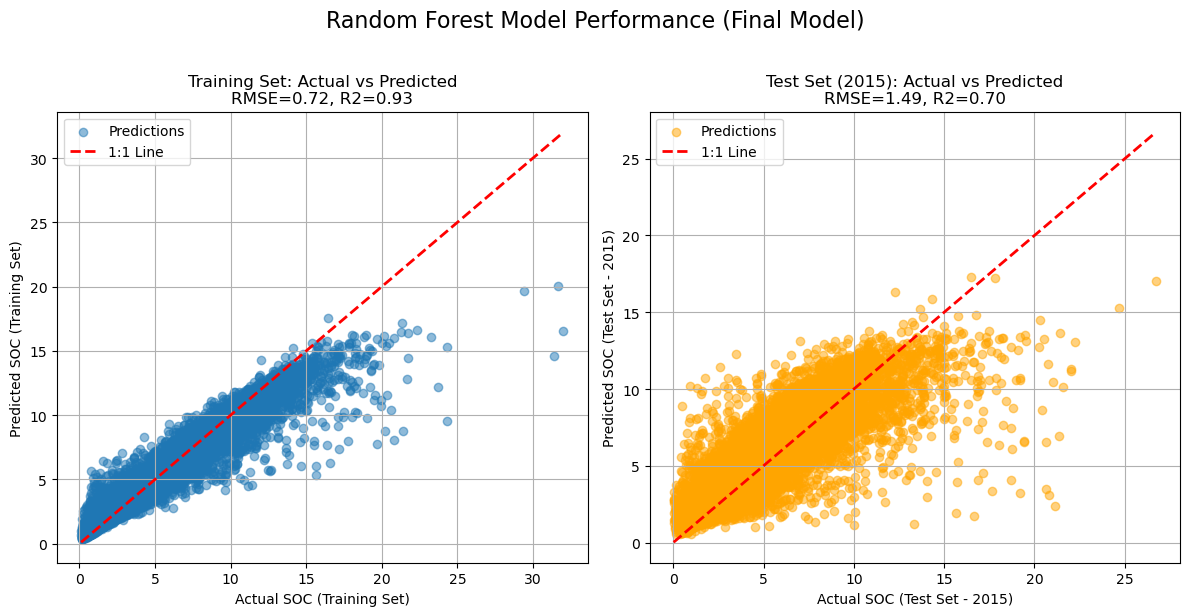


Explanation of Chart 1 (True vs. Predicted - Train & Test):
These scatter plots show the performance of the *final* Random Forest model (trained on the entire 2009+2018 dataset) on both the training data (left) and the independent 2015 test data (right).
Points close to the 1:1 line indicate good prediction accuracy.
Comparing the train vs. test plot helps identify overfitting: training performance is usually better than test performance, but a large gap suggests overfitting.

Plotting Residuals vs. Predicted Values (Test Set)...


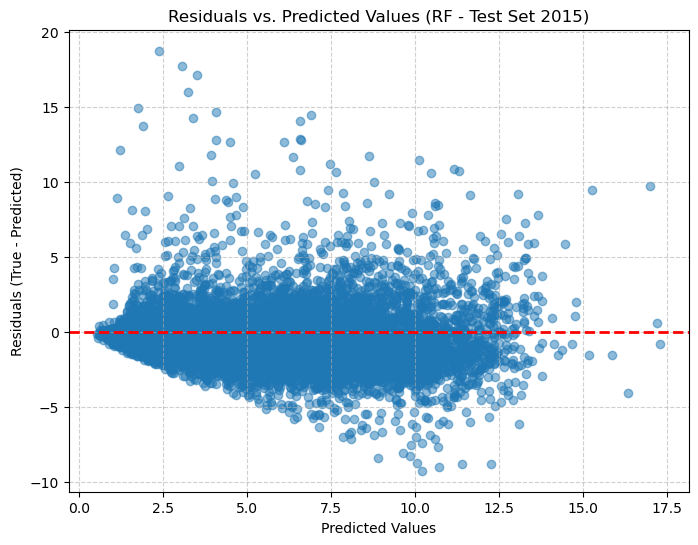


Explanation of Chart 2 (Residuals vs. Predicted - Test Set):
This plot shows the prediction errors on the 2015 test set against the predicted values. Ideally, residuals should be randomly scattered around the zero line with no pattern.
Any patterns (e.g., trends, fanning out/in) can indicate issues like non-linearity or heteroscedasticity that the model didn't fully capture.

Plotting Residuals Distribution Histogram (Test Set)...


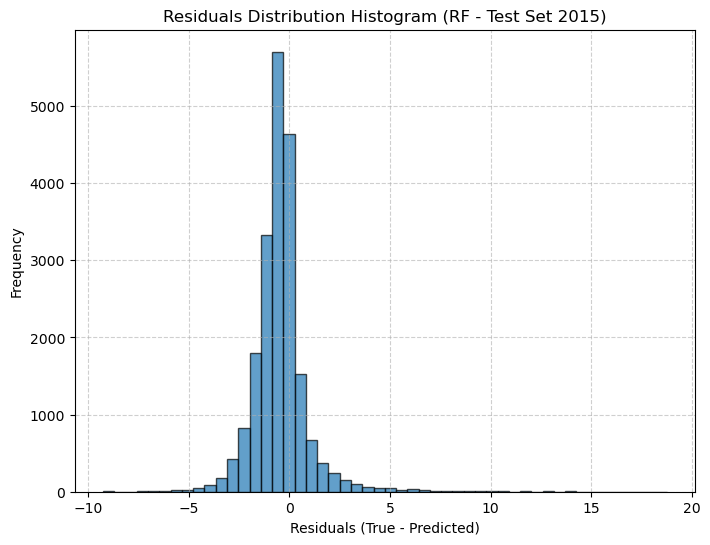


Explanation of Chart 3 (Residuals Histogram - Test Set):
This histogram shows the distribution of prediction errors on the 2015 test set. Ideally, residuals should be symmetrically distributed around zero, resembling a normal (bell) curve. A distribution skewed away from zero or having multiple peaks might suggest issues.

Plotting Feature Importance...


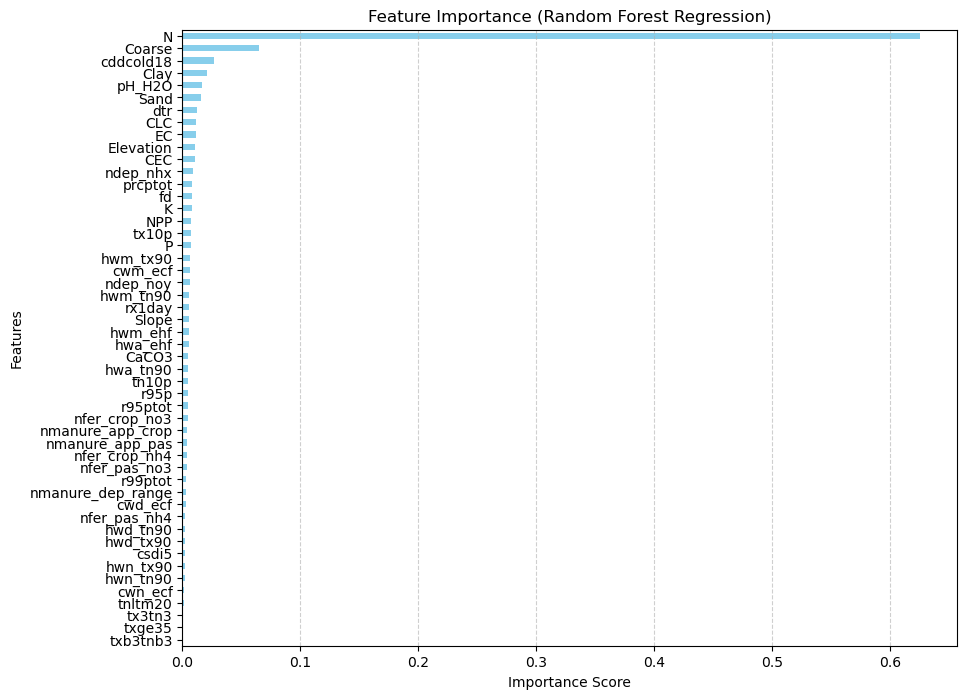

Feature Importance plot generated.

Explanation of Chart 4 (Feature Importance):
This horizontal bar chart shows the relative importance of each input feature as determined by the final Random Forest model.
The score indicates how much that feature contributed to the model's predictive performance across all trees.
Features with longer bars (higher scores) are considered more influential drivers of the target variable.

Plotting Performance vs. Hyperparameters (from Custom CV results)...

Plotting Performance vs. Number of Estimators (using Avg 2015 Test RMSE)...


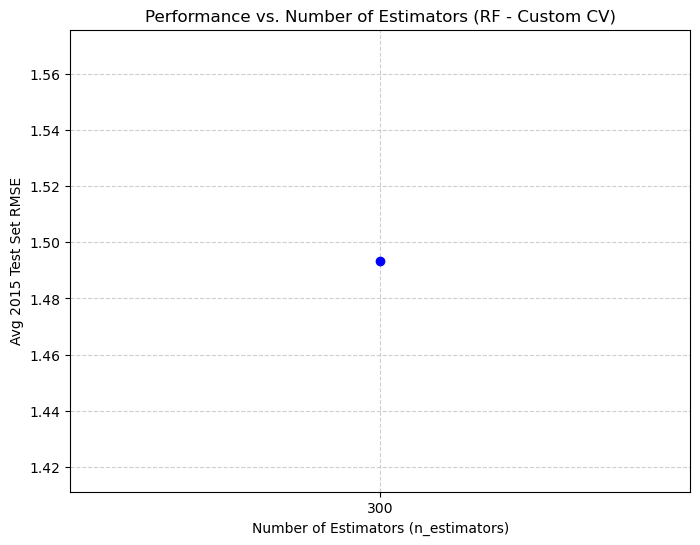

Performance vs. Number of Estimators plot generated.

Explanation of Performance vs. Number of Estimators Plot:
This plot shows the best average RMSE on the 2015 test set for each 'n_estimators' value tested during the custom CV.
It helps see the trend of performance improvement as more trees are added.

Plotting Performance vs. Max Depth (using Avg 2015 Test RMSE)...


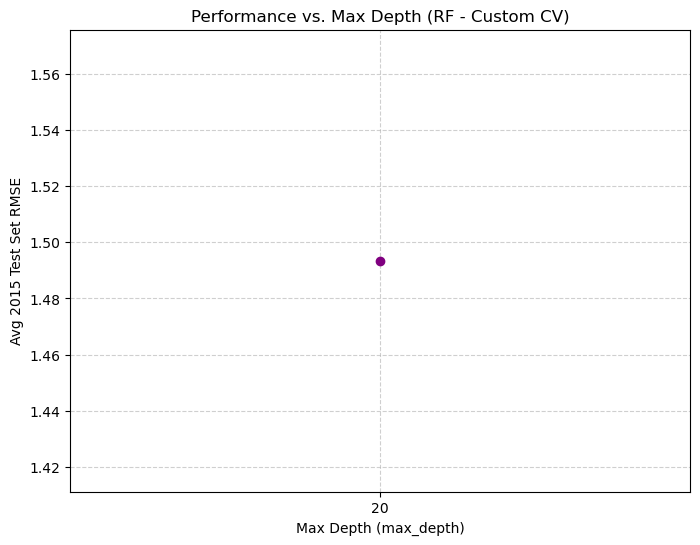

Performance vs. Max Depth plot generated.

Explanation of Performance vs. Max Depth Plot:
This plot shows the best average RMSE on the 2015 test set for each 'max_depth' value tested during the custom CV.
Deeper trees can capture more complex patterns but increase the risk of overfitting.

Skipping Test Score vs. Boosting Iterations plot for Random Forest.
Explanation: This plot is only applicable to Boosting models (like GBM), which build trees sequentially and provide staged performance metrics.

--- Random Forest Charting Complete ---


: 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Assumed variables available from the custom CV script:
# y_train_full, y_pred_final_train
# y_test, y_pred_final_test
# final_model
# covariate_names
# results_list
# X_test_scaled (technically not used in plotting, but was used in the CV and final prediction)

print("\n--- Plotting Random Forest Evaluation and Analysis Charts based on Custom CV Results ---")

# --- Calculate Residuals for Test Set ---
residuals_test = y_test - y_pred_final_test

# --- Chart 1: True vs. Predicted Values Scatter Plot (Train & Test Subplots) ---
print("\nPlotting True vs. Predicted Values (Train & Test)...")
plt.figure(figsize=(12, 6))

# Training Set Subplot
plt.subplot(1, 2, 1)
plt.scatter(y_train_full, y_pred_final_train, alpha=0.5, label='Predictions')
min_val_train = min(y_train_full.min(), y_pred_final_train.min())
max_val_train = max(y_train_full.max(), y_pred_final_train.max())
plt.plot([min_val_train, max_val_train], [min_val_train, max_val_train], 'r--', lw=2, label='1:1 Line')
plt.xlabel("Actual SOC (Training Set)")
plt.ylabel("Predicted SOC (Training Set)")
# Calculate train metrics for the final model if needed for the title
final_rmse_train = np.sqrt(mean_squared_error(y_train_full, y_pred_final_train))
final_r2_train = r2_score(y_train_full, y_pred_final_train)
plt.title(f"Training Set: Actual vs Predicted\nRMSE={final_rmse_train:.2f}, R2={final_r2_train:.2f}")
plt.legend()
plt.grid(True)

# Test Set Subplot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_final_test, alpha=0.5, label='Predictions', color='orange')
min_val_test = min(y_test.min(), y_pred_final_test.min())
max_val_test = max(y_test.max(), y_pred_final_test.max())
plt.plot([min_val_test, max_val_test], [min_val_test, max_val_test], 'r--', lw=2, label='1:1 Line')
plt.xlabel("Actual SOC (Test Set - 2015)")
plt.ylabel("Predicted SOC (Test Set - 2015)")
# Use the already calculated final_rmse_test, final_r2_test from the custom CV evaluation step
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test)) # Recalculate for safety if not stored
final_r2_test = r2_score(y_test, y_pred_final_test)                 # Recalculate for safety if not stored
plt.title(f"Test Set (2015): Actual vs Predicted\nRMSE={final_rmse_test:.2f}, R2={final_r2_test:.2f}")
plt.legend()
plt.grid(True)

plt.suptitle('Random Forest Model Performance (Final Model)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# --- Explanation of Chart 1 ---
print("\nExplanation of Chart 1 (True vs. Predicted - Train & Test):")
print("These scatter plots show the performance of the *final* Random Forest model (trained on the entire 2009+2018 dataset) on both the training data (left) and the independent 2015 test data (right).")
print("Points close to the 1:1 line indicate good prediction accuracy.")
print("Comparing the train vs. test plot helps identify overfitting: training performance is usually better than test performance, but a large gap suggests overfitting.")


# --- Chart 2: Residuals vs. Predicted Values Scatter Plot (Test Set) ---
print("\nPlotting Residuals vs. Predicted Values (Test Set)...")
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_final_test, residuals_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2) # Draw a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs. Predicted Values (RF - Test Set 2015)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Explanation of Chart 2 ---
print("\nExplanation of Chart 2 (Residuals vs. Predicted - Test Set):")
print("This plot shows the prediction errors on the 2015 test set against the predicted values. Ideally, residuals should be randomly scattered around the zero line with no pattern.")
print("Any patterns (e.g., trends, fanning out/in) can indicate issues like non-linearity or heteroscedasticity that the model didn't fully capture.")


# --- Chart 3: Residuals Distribution Histogram (Test Set) ---
print("\nPlotting Residuals Distribution Histogram (Test Set)...")
plt.figure(figsize=(8, 6))
# Adjust bins as needed based on your data's residual distribution spread
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution Histogram (RF - Test Set 2015)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Explanation of Chart 3 ---
print("\nExplanation of Chart 3 (Residuals Histogram - Test Set):")
print("This histogram shows the distribution of prediction errors on the 2015 test set. Ideally, residuals should be symmetrically distributed around zero, resembling a normal (bell) curve. A distribution skewed away from zero or having multiple peaks might suggest issues.")


# --- Chart 4: Feature Importance Horizontal Bar Chart ---
print("\nPlotting Feature Importance...")
try:
    # Get feature importances from the final trained model
    importances = final_model.feature_importances_

    # Ensure the number of importances matches the number of feature names
    if len(importances) != len(covariate_names):
         print("Error: Number of feature importances does not match the number of feature names. Cannot plot Feature Importance.")
    else:
        feature_importance_rf = pd.Series(importances, index=covariate_names)
        feature_importance_rf = feature_importance_rf.sort_values(ascending=True) # Sort ascending for barh

        plt.figure(figsize=(10, 8)) # Adjust size as needed
        feature_importance_rf.plot(kind='barh', color='skyblue') # Use a color for RF

        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.title('Feature Importance (Random Forest Regression)')
        plt.grid(axis='x', linestyle='--', alpha=0.6) # Add vertical grid lines
        plt.show()
        print("Feature Importance plot generated.")

    # --- Explanation of Chart 4 ---
    print("\nExplanation of Chart 4 (Feature Importance):")
    print("This horizontal bar chart shows the relative importance of each input feature as determined by the final Random Forest model.")
    print("The score indicates how much that feature contributed to the model's predictive performance across all trees.")
    print("Features with longer bars (higher scores) are considered more influential drivers of the target variable.")

except AttributeError:
    print("\nSkipping Feature Importance plot: The final_model object does not have 'feature_importances_' attribute (unexpected for RandomForestRegressor, check model type).")
except Exception as e:
    print(f"\nError generating Feature Importance plot: {e}")


# --- Chart 5: Performance (Average 2015 Test RMSE) vs. Hyperparameters (from Custom CV results) ---
print("\nPlotting Performance vs. Hyperparameters (from Custom CV results)...")

# Convert results_list to DataFrame for easier plotting
if not results_list:
    print("\nSkipping Performance vs. Hyperparameters plots: results_list is empty or not available.")
else:
    results_df = pd.DataFrame(results_list)

    # Check if the 'params' column exists and is not empty (indicates parameters were varied)
    if 'params' in results_df.columns and len(results_df['params']) > 0:

        # --- Plot vs n_estimators ---
        # Check if n_estimators was a varied parameter in the grid
        # Access the first dictionary in 'params' column to check for keys
        if 'n_estimators' in results_df['params'].iloc[0]:
            print("\nPlotting Performance vs. Number of Estimators (using Avg 2015 Test RMSE)...")
            # Extract n_estimators and avg_rmse_2015 for each result entry
            n_estimators_values = [res['params'].get('n_estimators') for res in results_list]
            rmse_2015_values = [res['avg_rmse_2015'] for res in results_list]

            # Create a temporary DataFrame to handle cases where other parameters were varied
            # Group by n_estimators and show the minimum RMSE achieved for that n_estimators value
            temp_plot_data = pd.DataFrame({'n_estimators': n_estimators_values, 'rmse_2015': rmse_2015_values})
            grouped_performance = temp_plot_data.groupby('n_estimators')['rmse_2015'].min()

            plt.figure(figsize=(8, 6))
            plt.plot(grouped_performance.index, grouped_performance.values, marker='o', linestyle='-', color='blue')

            plt.xlabel('Number of Estimators (n_estimators)')
            plt.ylabel('Avg 2015 Test Set RMSE') # Label clearly indicates the metric and set
            plt.title('Performance vs. Number of Estimators (RF - Custom CV)')
            plt.grid(True, linestyle='--', alpha=0.6)
            if len(grouped_performance.index) < 15: # Only set x-ticks if there aren't too many
                 plt.xticks(grouped_performance.index)
            plt.show()
            print("Performance vs. Number of Estimators plot generated.")
            # --- Explanation of Chart 5 (part 1) ---
            print("\nExplanation of Performance vs. Number of Estimators Plot:")
            print("This plot shows the best average RMSE on the 2015 test set for each 'n_estimators' value tested during the custom CV.")
            print("It helps see the trend of performance improvement as more trees are added.")


        # --- Plot vs max_depth ---
        # Check if max_depth was a varied parameter
        if 'max_depth' in results_df['params'].iloc[0]:
            print("\nPlotting Performance vs. Max Depth (using Avg 2015 Test RMSE)...")
            max_depth_values = [res['params'].get('max_depth') for res in results_list]
            rmse_2015_values_md = [res['avg_rmse_2015'] for res in results_list]

            temp_plot_data_md = pd.DataFrame({'max_depth': max_depth_values, 'rmse_2015': rmse_2015_values_md})
            # Handle None values in max_depth if they exist for sorting
            temp_plot_data_md['max_depth_sort'] = temp_plot_data_md['max_depth'].apply(lambda x: x if x is not None else 9999)
            grouped_performance_md = temp_plot_data_md.groupby('max_depth_sort')['rmse_2015'].min().sort_index()
            # Map the index back to None for plotting
            grouped_performance_md.index = grouped_performance_md.index.map(lambda x: x if x != 9999 else None)

            plot_indices_md = grouped_performance_md.index
            plot_values_md = grouped_performance_md.values
            # Sort based on the actual depth value, handling None (None should come last)
            sorted_indices_values = sorted(zip(plot_indices_md, plot_values_md), key=lambda x: x[0] if x[0] is not None else float('inf'))
            sorted_indices_md, sorted_values_md = zip(*sorted_indices_values)


            plt.figure(figsize=(8, 6))
            # Plot against integer index and set x-ticks to actual values
            plt.plot(range(len(sorted_indices_md)), sorted_values_md, marker='o', linestyle='-', color='purple')
            plt.xticks(range(len(sorted_indices_md)), sorted_indices_md)

            plt.xlabel('Max Depth (max_depth)')
            plt.ylabel('Avg 2015 Test Set RMSE')
            plt.title('Performance vs. Max Depth (RF - Custom CV)')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
            print("Performance vs. Max Depth plot generated.")

            # --- Explanation of Chart 5 (part 2) ---
            print("\nExplanation of Performance vs. Max Depth Plot:")
            print("This plot shows the best average RMSE on the 2015 test set for each 'max_depth' value tested during the custom CV.")
            print("Deeper trees can capture more complex patterns but increase the risk of overfitting.")

        # --- Add plots for other varied parameters like min_samples_split, min_samples_leaf, max_features, subsample ---
        # You can add more plots here following the structure above, checking if the corresponding parameter name
        # exists as a key in results_df['params'].iloc[0] and then extracting/plotting.

    else:
        print("\nSkipping Performance vs. Hyperparameters plots: No varying parameters found in results_list['params'].")


# --- Chart 6: Test Score vs. Boosting Iterations (Loss Curve) ---
# This plot is SPECIFIC to Boosting models like GBM or AdaBoost.
# Standard Random Forest does NOT have a 'staged_score' method.
print("\nSkipping Test Score vs. Boosting Iterations plot for Random Forest.")
print("Explanation: This plot is only applicable to Boosting models (like GBM), which build trees sequentially and provide staged performance metrics.")


print("\n--- Random Forest Charting Complete ---")


--- Plotting Random Forest Evaluation and Analysis Charts ---

Plotting True vs. Predicted Values...


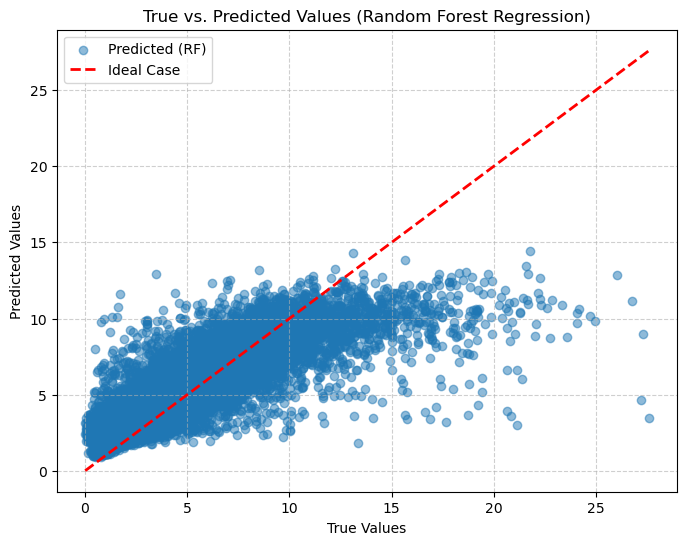


Explanation of True vs. Predicted Plot:
This scatter plot shows the relationship between the actual observed values (True Values) and the values predicted by the final Random Forest model (Predicted Values) on the independent 2015 test set.
Points close to the red 1:1 diagonal line indicate accurate predictions. The closer the points are to the line, the better the model's performance.

Plotting Residuals vs. Predicted Values...


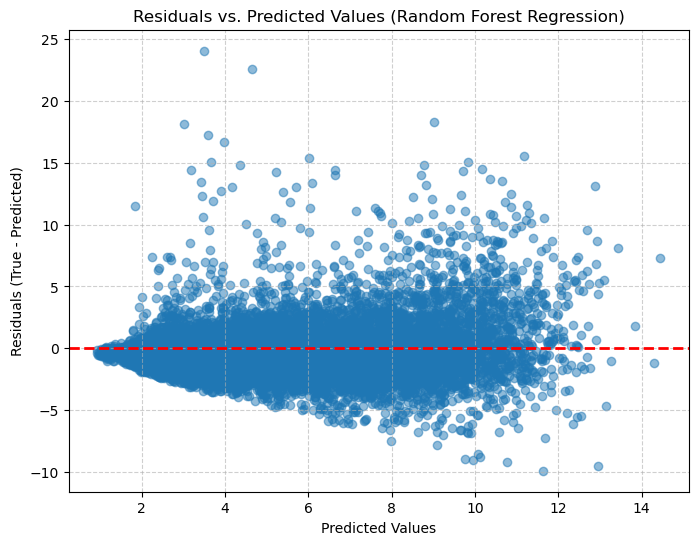


Explanation of Residuals vs. Predicted Plot:
This plot shows the prediction errors (Residuals) on the Y-axis against the predicted values on the X-axis.
For a well-performing regression model, the residuals should be randomly scattered around the horizontal line at Y=0 with no clear pattern.
Any patterns (e.g., trends, fanning out/in) can indicate issues like non-linearity or heteroscedasticity that the model didn't fully capture.

Plotting Residuals Distribution Histogram...


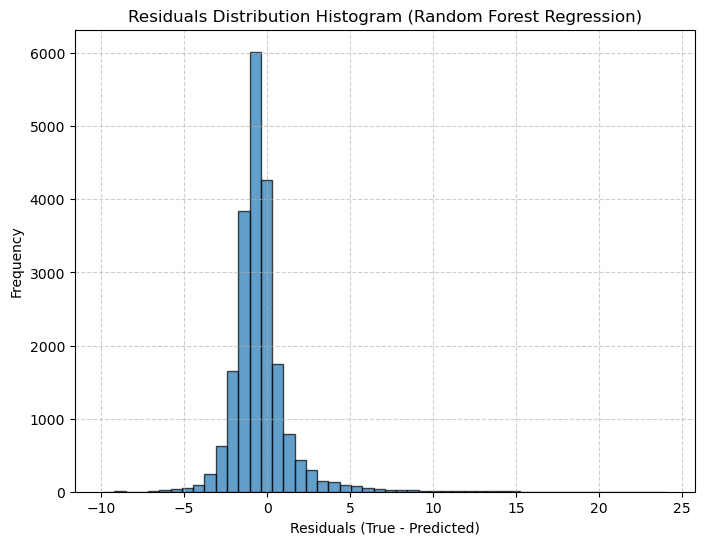


Explanation of Residuals Distribution Histogram:
This histogram shows how frequently different ranges of residual values occur.
Ideally, the residuals should be symmetrically distributed around zero, resembling a normal (bell) curve. A distribution skewed away from zero or having multiple peaks might suggest issues.

Plotting Feature Importance...


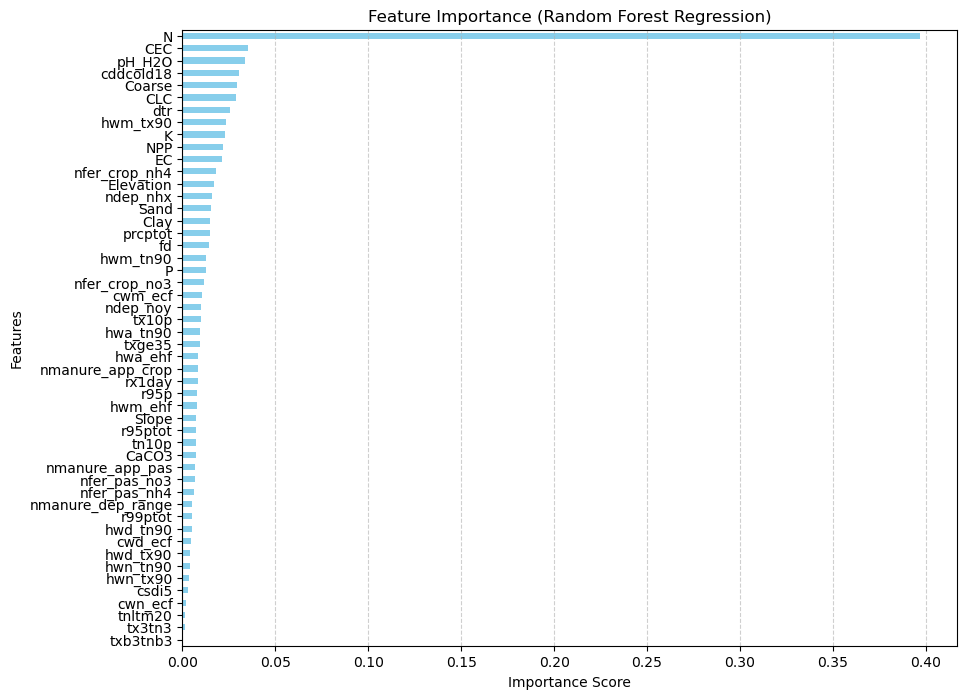

Feature Importance plot generated.

Explanation of Feature Importance Plot:
This horizontal bar chart shows the relative importance of each input feature as determined by the final Random Forest model.
The score indicates how much that feature contributed to the model's predictive performance across all trees.
Features with longer bars (higher scores) are considered more influential drivers of the target variable.

Plotting Performance vs. Hyperparameters (from Custom CV results)...

Plotting Performance vs. Number of Estimators (using 2015 Test RMSE)...


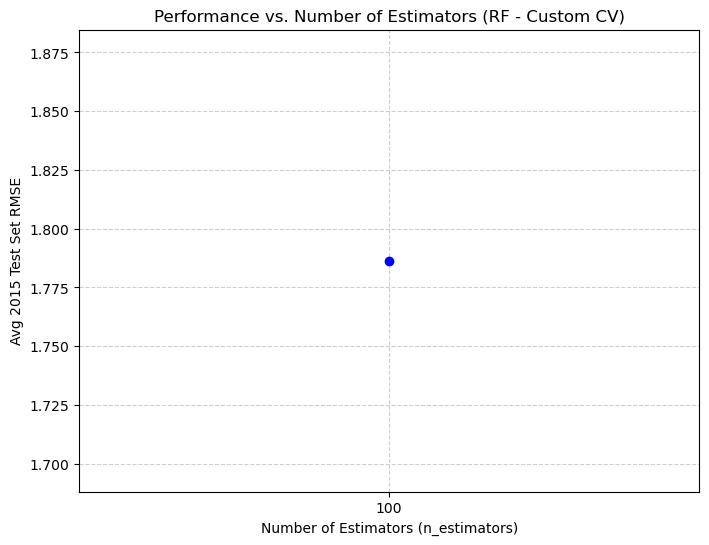

Performance vs. Number of Estimators plot generated.

Explanation of Performance vs. Number of Estimators Plot:
This plot shows how the model's performance (measured by the average RMSE on the independent 2015 test set, calculated across the 9 CV folds) changes as you increase the number of trees (estimators).
It helps see the trend of performance improvement as more trees are added.

Plotting Performance vs. Max Depth (using 2015 Test RMSE)...


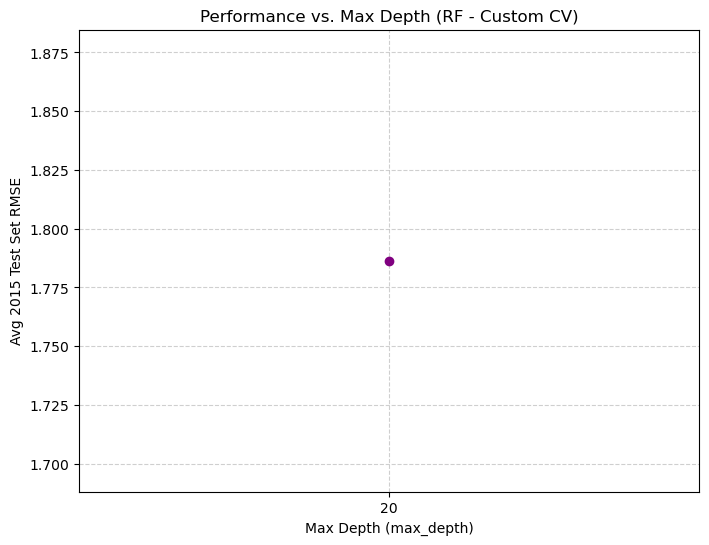

Performance vs. Max Depth plot generated.

Explanation of Performance vs. Max Depth Plot:
This plot shows how the model's performance (average RMSE on the 2015 test set) changes with the maximum allowed depth of individual trees in the Random Forest.
Deeper trees can capture more complex patterns but increase the risk of overfitting.

Skipping Test Score vs. Boosting Iterations plot.
Explanation: This plot is only applicable to Boosting models (like GBM), which build trees sequentially.
Standard Random Forest builds trees in parallel and does not have a 'staged_score' method to show performance evolution during boosting iterations.

--- Random Forest Charting Complete ---


In [6]:
# Assumed variables available from the custom CV script:
# y_test (Original 2015 SOC test data)
# y_pred_final_test (Predictions of final_model on X_test_scaled)
# final_model (The best model trained on the whole 2009+2018 data)
# covariate_names (List of final feature names)
# results_list (List of dictionaries containing results for each parameter combination)
# X_test_scaled (Scaled 2015 test features - needed for staged_score if applicable)

# Note: Standard Random Forest models do not have a 'staged_score' method.
# The 'Test Score vs. Boosting Iterations' plot is not applicable to standard RF.

print("\n--- Plotting Random Forest Evaluation and Analysis Charts ---")

# --- Calculate Residuals ---
residuals_test = y_test - y_pred_final_test

# --- Chart 1: True vs. Predicted Values Scatter Plot ---
print("\nPlotting True vs. Predicted Values...")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final_test, alpha=0.5, label='Predicted (RF)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values (Random Forest Regression)')
min_val_plot1 = min(y_test.min(), y_pred_final_test.min())
max_val_plot1 = max(y_test.max(), y_pred_final_test.max())
plt.plot([min_val_plot1, max_val_plot1], [min_val_plot1, max_val_plot1], 'r--', lw=2, label='Ideal Case')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# --- Explanation of Chart 1 ---
print("\nExplanation of True vs. Predicted Plot:")
print("This scatter plot shows the relationship between the actual observed values (True Values) and the values predicted by the final Random Forest model (Predicted Values) on the independent 2015 test set.")
print("Points close to the red 1:1 diagonal line indicate accurate predictions. The closer the points are to the line, the better the model's performance.")


# --- Chart 2: Residuals vs. Predicted Values Scatter Plot ---
print("\nPlotting Residuals vs. Predicted Values...")
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_final_test, residuals_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2) # Draw a horizontal line at y=0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs. Predicted Values (Random Forest Regression)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Explanation of Chart 2 ---
print("\nExplanation of Residuals vs. Predicted Plot:")
print("This plot shows the prediction errors (Residuals) on the Y-axis against the predicted values on the X-axis.")
print("For a well-performing regression model, the residuals should be randomly scattered around the horizontal line at Y=0 with no clear pattern.")
print("Any patterns (e.g., trends, fanning out/in) can indicate issues like non-linearity or heteroscedasticity that the model didn't fully capture.")


# --- Chart 3: Residuals Distribution Histogram ---
print("\nPlotting Residuals Distribution Histogram...")
plt.figure(figsize=(8, 6))
# Adjust bins as needed based on your data's residual distribution spread
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution Histogram (Random Forest Regression)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Explanation of Chart 3 ---
print("\nExplanation of Residuals Distribution Histogram:")
print("This histogram shows how frequently different ranges of residual values occur.")
print("Ideally, the residuals should be symmetrically distributed around zero, resembling a normal (bell) curve. A distribution skewed away from zero or having multiple peaks might suggest issues.")


# --- Chart 4: Feature Importance Horizontal Bar Chart ---
print("\nPlotting Feature Importance...")
try:
    importances = final_model.feature_importances_

    # Check if the number of importances matches the number of feature names
    if len(importances) != len(covariate_names):
         print("Error: Number of feature importances does not match the number of feature names. Cannot plot.")
    else:
        feature_importance_rf = pd.Series(importances, index=covariate_names)
        feature_importance_rf = feature_importance_rf.sort_values(ascending=True) # Sort ascending for barh

        plt.figure(figsize=(10, 8)) # Adjust size as needed
        feature_importance_rf.plot(kind='barh', color='skyblue') # Use a color for RF

        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.title('Feature Importance (Random Forest Regression)')
        plt.grid(axis='x', linestyle='--', alpha=0.6) # Add vertical grid lines
        plt.show()
        print("Feature Importance plot generated.")

    # --- Explanation of Chart 4 ---
    print("\nExplanation of Feature Importance Plot:")
    print("This horizontal bar chart shows the relative importance of each input feature as determined by the final Random Forest model.")
    print("The score indicates how much that feature contributed to the model's predictive performance across all trees.")
    print("Features with longer bars (higher scores) are considered more influential drivers of the target variable.")

except AttributeError:
    print("\nSkipping Feature Importance plot: The final_model object does not have 'feature_importances_' attribute (unexpected for RandomForestRegressor).")
except Exception as e:
    print(f"\nError generating Feature Importance plot: {e}")


# --- Chart 5: Performance (Average RMSE on 2015 Test Set) vs. Hyperparameters (from Custom CV results) ---
print("\nPlotting Performance vs. Hyperparameters (from Custom CV results)...")

# Convert results_list to DataFrame for easier plotting, or extract data directly
results_df = pd.DataFrame(results_list)

# Plot vs n_estimators (Example)
if 'n_estimators' in results_df['params'][0]: # Check if n_estimators was a varied parameter
    print("\nPlotting Performance vs. Number of Estimators (using 2015 Test RMSE)...")
    # Extract n_estimators and avg_rmse_2015 for each result
    n_estimators_values = [res['params'].get('n_estimators') for res in results_list]
    rmse_2015_values = [res['avg_rmse_2015'] for res in results_list]

    # Create a temporary DataFrame to handle potential multiple results for the same n_estimators
    # if other parameters were varied. Group by n_estimators and show min RMSE.
    temp_plot_data = pd.DataFrame({'n_estimators': n_estimators_values, 'rmse_2015': rmse_2015_values})
    grouped_performance = temp_plot_data.groupby('n_estimators')['rmse_2015'].min()


    plt.figure(figsize=(8, 6))
    plt.plot(grouped_performance.index, grouped_performance.values, marker='o', linestyle='-', color='blue')

    plt.xlabel('Number of Estimators (n_estimators)')
    plt.ylabel('Avg 2015 Test Set RMSE') # Label clearly indicates the metric and set
    plt.title('Performance vs. Number of Estimators (RF - Custom CV)')
    plt.grid(True, linestyle='--', alpha=0.6)
    if len(grouped_performance.index) < 15: # Only set x-ticks if there aren't too many
         plt.xticks(grouped_performance.index)
    plt.show()
    print("Performance vs. Number of Estimators plot generated.")

    # --- Explanation of Chart 5 (part 1) ---
    print("\nExplanation of Performance vs. Number of Estimators Plot:")
    print("This plot shows how the model's performance (measured by the average RMSE on the independent 2015 test set, calculated across the 9 CV folds) changes as you increase the number of trees (estimators).")
    print("It helps see the trend of performance improvement as more trees are added.")


# Plot vs max_depth (Example)
if 'max_depth' in results_df['params'][0]: # Check if max_depth was a varied parameter
    print("\nPlotting Performance vs. Max Depth (using 2015 Test RMSE)...")
    # Extract max_depth and avg_rmse_2015 for each result
    max_depth_values = [res['params'].get('max_depth') for res in results_list]
    rmse_2015_values_md = [res['avg_rmse_2015'] for res in results_list]

    # Create a temporary DataFrame to handle potential multiple results for the same max_depth
    temp_plot_data_md = pd.DataFrame({'max_depth': max_depth_values, 'rmse_2015': rmse_2015_values_md})
    # Need to handle None values in max_depth if they exist
    temp_plot_data_md['max_depth_sort'] = temp_plot_data_md['max_depth'].apply(lambda x: x if x is not None else 9999) # Assign large number for sorting None

    grouped_performance_md = temp_plot_data_md.groupby('max_depth_sort')['rmse_2015'].min().sort_index()
    # Replace the sorting value back with None for plotting
    grouped_performance_md.index = grouped_performance_md.index.map(lambda x: x if x != 9999 else None)


    plt.figure(figsize=(8, 6))
    # Ensure max_depth values are plotted in increasing order (handling None)
    plot_indices_md = grouped_performance_md.index
    plot_values_md = grouped_performance_md.values

    # Need to sort based on the actual depth value, handling None
    sorted_indices_values = sorted(zip(plot_indices_md, plot_values_md), key=lambda x: x[0] if x[0] is not None else float('inf'))

    sorted_indices_md, sorted_values_md = zip(*sorted_indices_values)


    plt.plot(range(len(sorted_indices_md)), sorted_values_md, marker='o', linestyle='-', color='purple') # Plot against index
    plt.xticks(range(len(sorted_indices_md)), sorted_indices_md) # Set ticks to actual max_depth values


    plt.xlabel('Max Depth (max_depth)')
    plt.ylabel('Avg 2015 Test Set RMSE')
    plt.title('Performance vs. Max Depth (RF - Custom CV)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    print("Performance vs. Max Depth plot generated.")

    # --- Explanation of Chart 5 (part 2) ---
    print("\nExplanation of Performance vs. Max Depth Plot:")
    print("This plot shows how the model's performance (average RMSE on the 2015 test set) changes with the maximum allowed depth of individual trees in the Random Forest.")
    print("Deeper trees can capture more complex patterns but increase the risk of overfitting.")


# --- Chart 6: Test Score vs. Boosting Iterations (Loss Curve) ---
# This plot is SPECIFIC to Boosting models like GBM or AdaBoost.
# Standard Random Forest does NOT have a 'staged_score' method.
print("\nSkipping Test Score vs. Boosting Iterations plot.")
print("Explanation: This plot is only applicable to Boosting models (like GBM), which build trees sequentially.")
print("Standard Random Forest builds trees in parallel and does not have a 'staged_score' method to show performance evolution during boosting iterations.")


print("\n--- Random Forest Charting Complete ---")

In [ ]:

# 定义9折交叉验证 
# 注意：GridSearchCV 会自动在 X_train_imputed 上进行9折分割和验证
# 它内部会把训练集分成9份，用8份训练，1份验证，重复9次，来评估每组超参数
cv_strategy = KFold(n_splits=9, shuffle=True, random_state=66) # shuffle=True 保证每次分割是随机的

# 配置GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv_strategy, # 使用9折交叉验证
    scoring='neg_mean_squared_error', # 使用负MSE作为评分，因为GridSearch默认找最大值，我们要最小化MSE
    n_jobs=-1,       # 使用所有CPU核心
    verbose=2        # 显示详细的搜索过程信息
)

print("\n开始进行网格搜索和9折交叉验证...")
# 在插补后的训练数据上执行搜索
grid_search.fit(X_train_imputed, y_train_full)
print("网格搜索完成.")

# 获取最佳参数和最佳模型
print("\n找到的最佳超参数组合:")
print(grid_search.best_params_)

best_rf_model = grid_search.best_estimator_
print("\n使用最佳参数训练得到的模型:")
print(best_rf_model)




开始进行网格搜索和9折交叉验证...
Fitting 9 folds for each of 1 candidates, totalling 9 fits
网格搜索完成.

找到的最佳超参数组合:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}

使用最佳参数训练得到的模型:
RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, random_state=66)


In [5]:

# --- 6. 模型评估 (问题5) ---
print("\n开始评估模型...")
# 在训练集上进行预测
y_pred_train = best_rf_model.predict(X_train_imputed)
# 在测试集 (2015年数据) 上进行预测
y_pred_test = best_rf_model.predict(X_test_imputed)

# 计算评估指标
# 训练集
mse_train = mean_squared_error(y_train_full, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_full, y_pred_train)

# 测试集
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n--- 模型评估结果 ---")
print(f"训练集 - RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"测试集 - RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")





开始评估模型...

--- 模型评估结果 ---
训练集 - RMSE: 1.6834, R2: 0.8867
测试集 - RMSE: 3.1408, R2: 0.5589



开始绘制结果图...


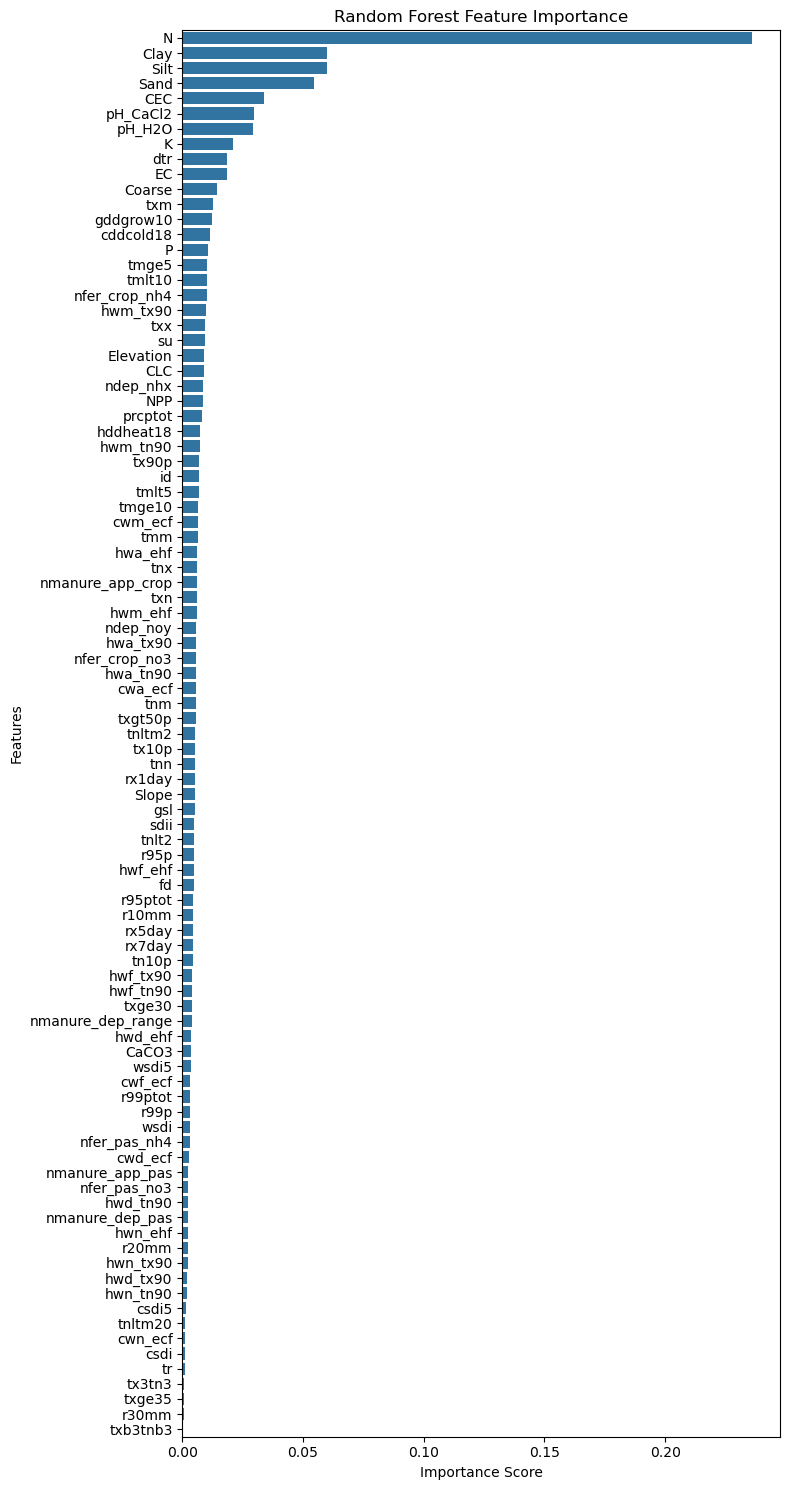

In [8]:

# --- 7. 结果可视化 (问题6) ---
print("\n开始绘制结果图...")

# (1) 特征重要性
importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': covariate_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


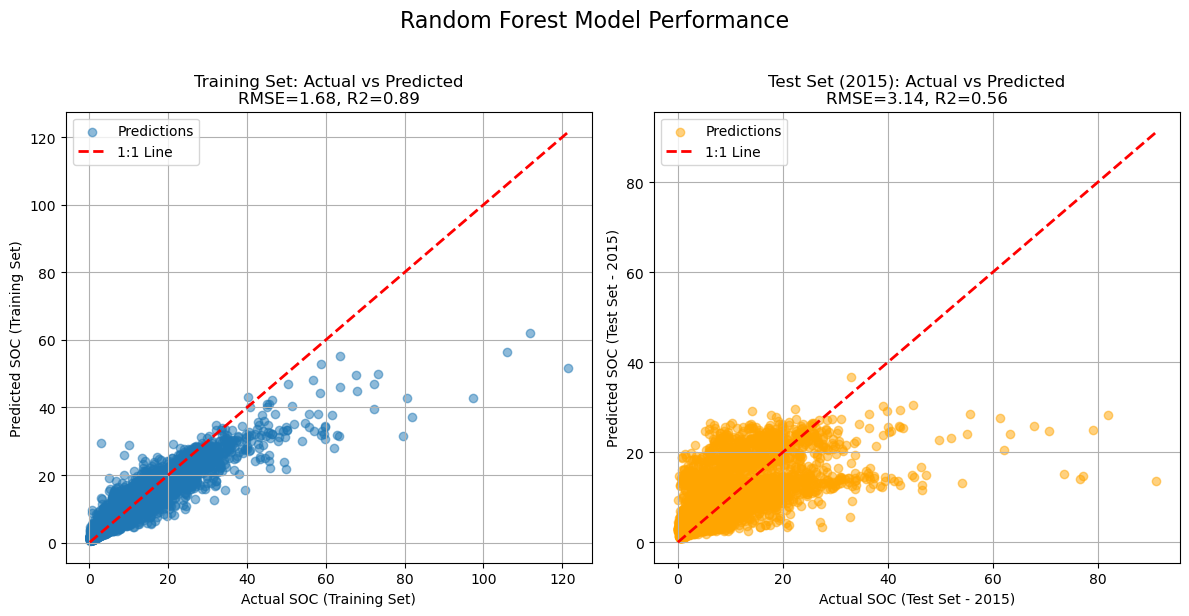


代码执行完毕.


In [ ]:

# (2) 预测值 vs 实际值散点图
plt.figure(figsize=(12, 6))

# 训练集
plt.subplot(1, 2, 1)
plt.scatter(y_train_full, y_pred_train, alpha=0.5, label='Predictions')
plt.plot([y_train_full.min(), y_train_full.max()], [y_train_full.min(), y_train_full.max()], 'r--', lw=2, label='1:1 Line')
plt.xlabel("Actual SOC (Training Set)")
plt.ylabel("Predicted SOC (Training Set)")
plt.title(f"Training Set: Actual vs Predicted\nRMSE={rmse_train:.2f}, R2={r2_train:.2f}")
plt.legend()
plt.grid(True)

# 测试集
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, label='Predictions', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='1:1 Line')
plt.xlabel("Actual SOC (Test Set - 2015)")
plt.ylabel("Predicted SOC (Test Set - 2015)")
plt.title(f"Test Set (2015): Actual vs Predicted\nRMSE={rmse_test:.2f}, R2={r2_test:.2f}")
plt.legend()
plt.grid(True)

plt.suptitle('Random Forest Model Performance', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n代码执行完毕.")


--- 开始进行部分依赖分析 (PDP/ICE) ---
将为以下最重要的 6 个特征绘制 PDP/ICE 图:
['N', 'Clay', 'Silt', 'Sand', 'CEC', 'pH_CaCl2']


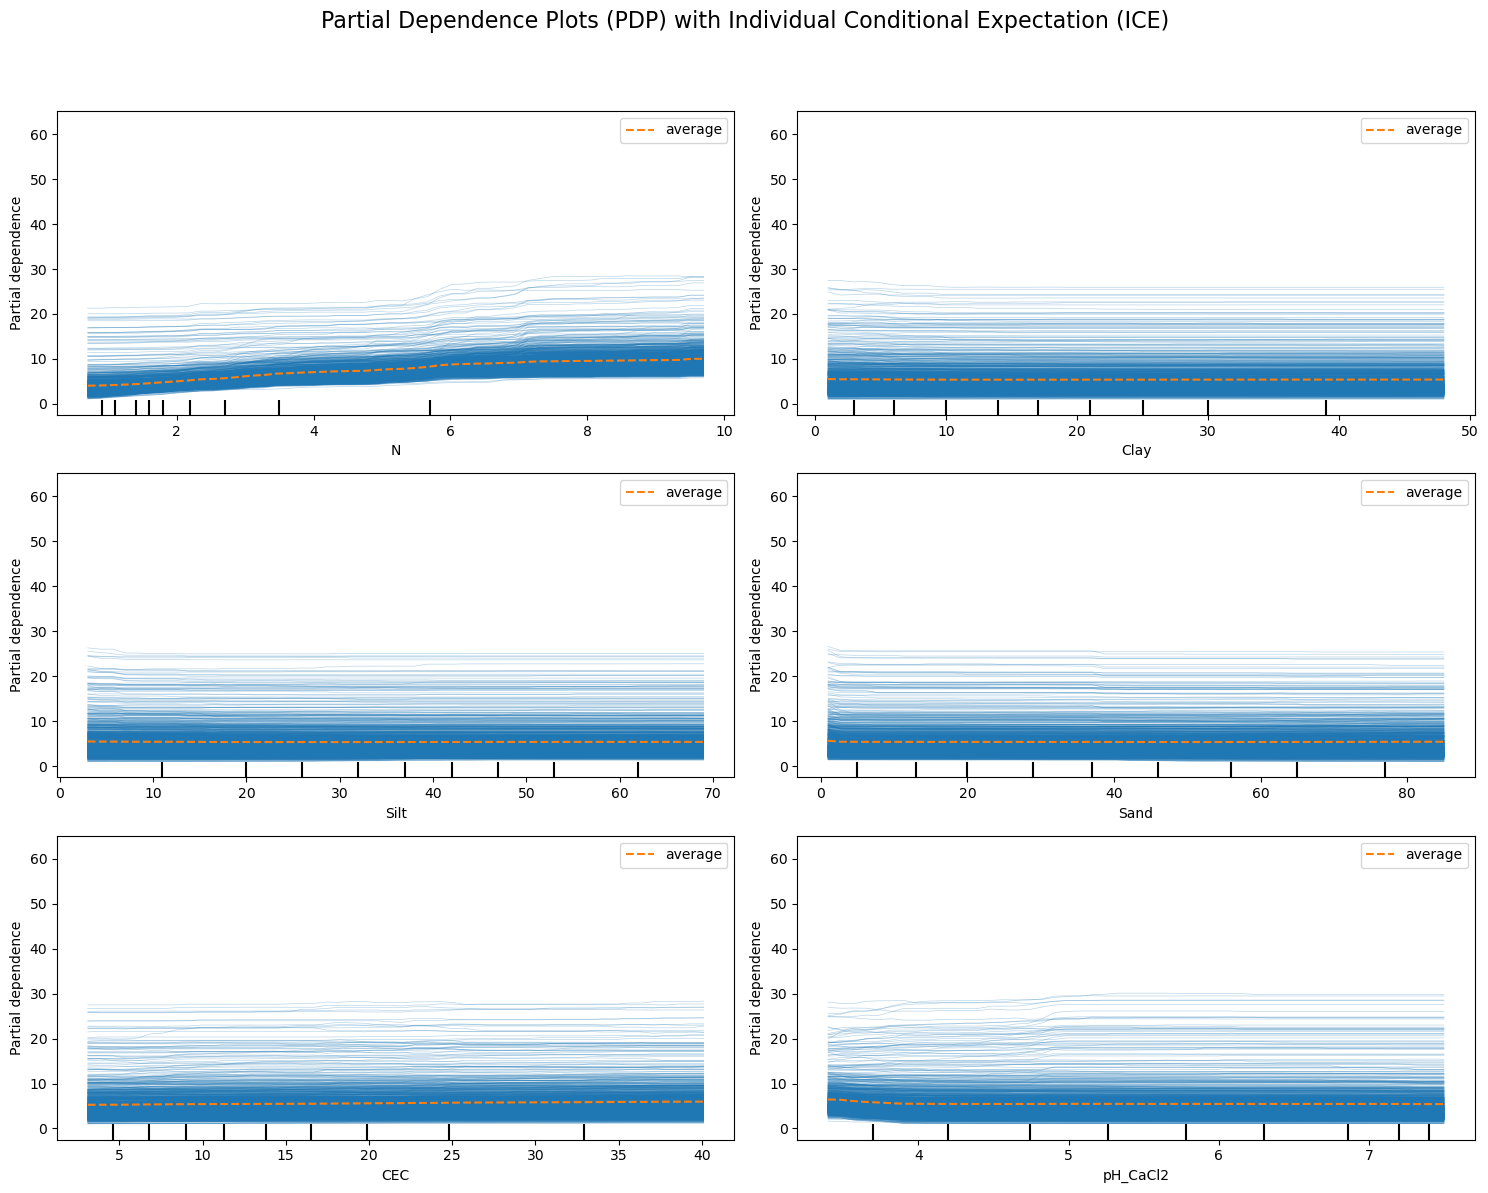


部分依赖分析绘图完成。
代码执行完毕。


In [10]:
from sklearn.inspection import PartialDependenceDisplay

# --- 8. 部分依赖分析和绘图 (Partial Dependence Plots - PDP) ---
print("\n--- 开始进行部分依赖分析 (PDP/ICE) ---")

# 选择要绘制PDP的最重要的N个特征
N_top_features = 6 # 你可以调整这个数量
top_features = feature_importance_df['Feature'].head(N_top_features).tolist()

print(f"将为以下最重要的 {N_top_features} 个特征绘制 PDP/ICE 图:")
print(top_features)

# --- 绘制 PDP 和 ICE 图 ---
# PartialDependenceDisplay.from_estimator 会自动处理图形布局
# kind='both' 会同时绘制 PDP（平均线）和 ICE（个体线）
# 使用训练数据 X_train_imputed 来计算依赖关系
# 'percentiles' 控制 x 轴范围，通常在数据的第 5 和第 95 百分位数之间显示，避免受极端值影响
# 'n_jobs' 可以加速计算过程
# 'grid_resolution' 控制计算 PDP/ICE 曲线时特征值的精细程度

# 注意：如果计算时间过长，可以尝试减少 N_top_features、降低 grid_resolution 或减少 ICE 线数量 (设置 subsample)
# 注意：对于分类特征（如 CLC，如果它是类别编码），PDP的解释需要谨慎。
#       最好在建模前对其进行独热编码（One-Hot Encoding），然后为每个独热编码后的虚拟变量绘制PDP。
#       如果 CLC 是数值编码（如 1, 2, 3...），当前的 PDP 会将其视为连续数值，可能难以解释。

try:
    fig, ax = plt.subplots(figsize=(15, 4 * ((N_top_features + 1) // 2)), # 调整图形大小以容纳子图
                         ncols=2, nrows=((N_top_features + 1) // 2)) # 创建子图网格

    display = PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_train_imputed, # 使用训练数据计算
        features=top_features, # 指定要绘制的特征列表
        kind='both', # 'average' 只绘制PDP, 'individual' 只绘制ICE, 'both' 都绘制
        subsample=1000, # 使用部分样本计算ICE线以加速（如果训练集很大），设为None或1.0使用全部
        n_jobs=-1, # 使用所有CPU核心
        grid_resolution=50, # x轴上的点数
        random_state=66,
        ax=ax.flatten()[:N_top_features] # 将图绘制到我们创建的子图上
    )

    # 调整布局和标题
    fig.suptitle('Partial Dependence Plots (PDP) with Individual Conditional Expectation (ICE)', fontsize=16, y=1.02)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局防止标题重叠

    # 如果子图数量是奇数，隐藏最后一个空的子图轴
    if N_top_features % 2 != 0:
        ax.flatten()[-1].set_visible(False)

    plt.show()

except Exception as e:
    print(f"绘制 PDP/ICE 图时出错: {e}")
    print("可能的原因包括：")
    print("- 内存不足（尝试减少 subsample 或 N_top_features）。")
    print("- 特征名称或数据类型问题。")
    print("- Scikit-learn 版本兼容性问题。")


print("\n部分依赖分析绘图完成。")
print("代码执行完毕。")

## OC

In [11]:
# --- 1. 读取数据 ---
try:
    df_2009 = pd.read_csv(r'D:\study/组会/data/SOC/soc_2009_complete.csv')
    df_2015 = pd.read_csv(r'D:\study/组会/data/SOC/soc_2015_complete.csv')
    df_2018 = pd.read_csv(r'D:\study/组会/data/SOC/soc_2018_complete.csv')
except FileNotFoundError:
    print("错误：请确保文件路径正确无误！")
    exit()
# --- 2. 定义协变量 (使用 iloc) 和目标变量 ---
# 问题2的解决方案
X_2009 = df_2009.iloc[:, 7:]
X_2015 = df_2015.iloc[:, 7:]
X_2018 = df_2018.iloc[:, 7:]

# 获取协变量名称（假设所有年份的协变量列名和顺序一致）
covariate_names = X_2009.columns.tolist()

Y_2009 = df_2009['OC']
Y_2015 = df_2015['OC'] 
Y_2018 = df_2018['OC'] 

# --- 3. 准备训练集和测试集 (按时间划分) ---
# 问题3: 训练集使用2009年和2018年的数据
X_train_full = pd.concat([X_2009, X_2018], ignore_index=True)
y_train_full = pd.concat([Y_2009, Y_2018], ignore_index=True)

# 问题3: 测试集使用2015年的数据
X_test = X_2015
y_test = Y_2015

print(f"训练集样本数: {X_train_full.shape[0]}")
print(f"测试集样本数: {X_test.shape[0]}")

# --- 4. 缺失值填补
# 最佳实践：仅用训练集数据拟合插补器
imputer = KNNImputer(n_neighbors=5, weights='distance')

# 拟合训练数据并转换训练数据
print("开始对训练集进行KNN插补...")
X_train_imputed = imputer.fit_transform(X_train_full)
print("训练集插补完成.")

# 转换测试数据 (注意：只用transform，不用fit)
print("开始对测试集进行KNN插补...")
X_test_imputed = imputer.transform(X_test)
print("测试集插补完成.")

# 转换回DataFrame以保留列名 (可选，但方便后续特征重要性分析)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=covariate_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=covariate_names)

# 检查插补后是否还有缺失值
print(f"插补后训练集缺失值数量: {X_train_imputed.isnull().sum().sum()}")
print(f"插补后测试集缺失值数量: {X_test_imputed.isnull().sum().sum()}")



训练集样本数: 40669
测试集样本数: 21859
开始对训练集进行KNN插补...
训练集插补完成.
开始对测试集进行KNN插补...
测试集插补完成.
插补后训练集缺失值数量: 0
插补后测试集缺失值数量: 0


In [12]:
# --- 5. 网格搜索与交叉验证进行超参数调优 
# 定义随机森林模型
rf = RandomForestRegressor(random_state=66) # 设置随机种子以便结果复现

# 定义要搜索的超参数网格
param_grid = {
    'n_estimators': [100],         # 树的数量
    'max_depth': [20],             # 树的最大深度
    'min_samples_split': [5],        # 节点分裂所需最小样本数
    'min_samples_leaf': [3],          # 叶节点最少样本数
    'max_features': ['sqrt']    # 寻找最佳分裂时考虑的特征数量 ('auto' 在新版本中等于 'sqrt')
}

# 定义9折交叉验证 
# 注意：GridSearchCV 会自动在 X_train_imputed 上进行9折分割和验证
# 它内部会把训练集分成9份，用8份训练，1份验证，重复9次，来评估每组超参数
cv_strategy = KFold(n_splits=9, shuffle=True, random_state=66) # shuffle=True 保证每次分割是随机的

# 配置GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv_strategy, # 使用9折交叉验证
    scoring='neg_mean_squared_error', # 使用负MSE作为评分，因为GridSearch默认找最大值，我们要最小化MSE
    n_jobs=-1,       # 使用所有CPU核心
    verbose=2        # 显示详细的搜索过程信息
)

print("\n开始进行网格搜索和9折交叉验证...")
# 在插补后的训练数据上执行搜索
grid_search.fit(X_train_imputed, y_train_full)
print("网格搜索完成.")

# 获取最佳参数和最佳模型
print("\n找到的最佳超参数组合:")
print(grid_search.best_params_)

best_rf_model = grid_search.best_estimator_
print("\n使用最佳参数训练得到的模型:")
print(best_rf_model)




开始进行网格搜索和9折交叉验证...
Fitting 9 folds for each of 1 candidates, totalling 9 fits
网格搜索完成.

找到的最佳超参数组合:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}

使用最佳参数训练得到的模型:
RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=5, random_state=66)


In [13]:

# --- 6. 模型评估 (问题5) ---
print("\n开始评估模型...")
# 在训练集上进行预测
y_pred_train = best_rf_model.predict(X_train_imputed)
# 在测试集 (2015年数据) 上进行预测
y_pred_test = best_rf_model.predict(X_test_imputed)

# 计算评估指标
# 训练集
mse_train = mean_squared_error(y_train_full, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_full, y_pred_train)

# 测试集
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n--- 模型评估结果 ---")
print(f"训练集 - RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"测试集 - RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")





开始评估模型...

--- 模型评估结果 ---
训练集 - RMSE: 12.3878, R2: 0.9786
测试集 - RMSE: 29.6584, R2: 0.8505



开始绘制结果图...


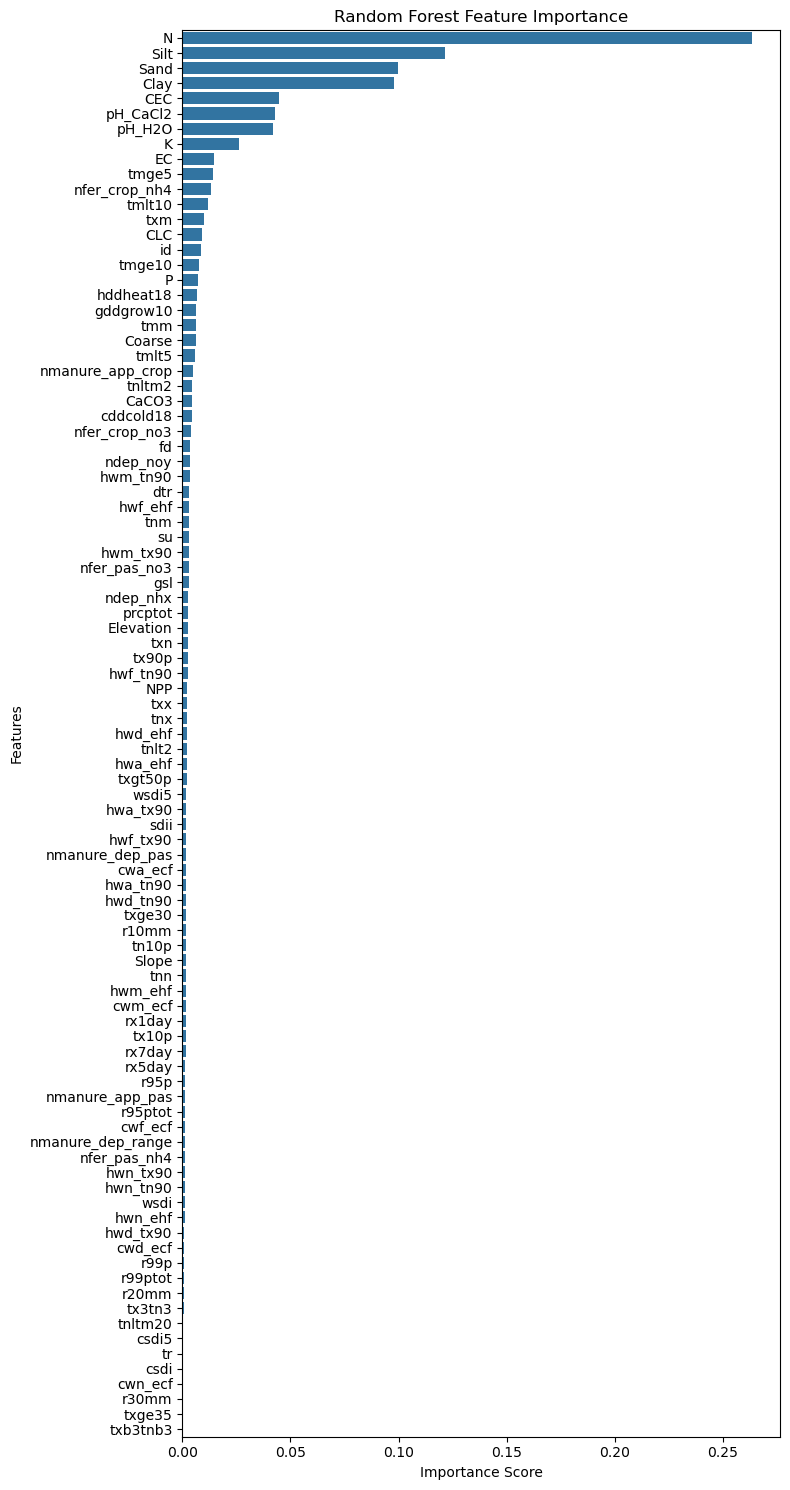

In [14]:

# --- 7. 结果可视化 (问题6) ---
print("\n开始绘制结果图...")

# (1) 特征重要性
importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': covariate_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


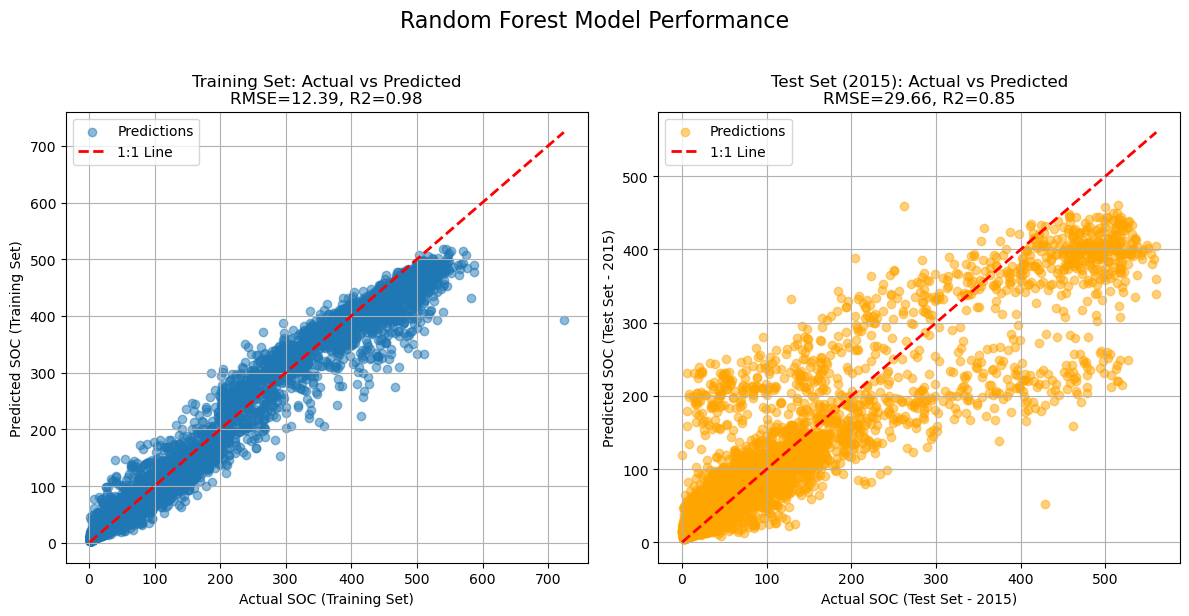


代码执行完毕.


In [15]:

# (2) 预测值 vs 实际值散点图
plt.figure(figsize=(12, 6))

# 训练集
plt.subplot(1, 2, 1)
plt.scatter(y_train_full, y_pred_train, alpha=0.5, label='Predictions')
plt.plot([y_train_full.min(), y_train_full.max()], [y_train_full.min(), y_train_full.max()], 'r--', lw=2, label='1:1 Line')
plt.xlabel("Actual SOC (Training Set)")
plt.ylabel("Predicted SOC (Training Set)")
plt.title(f"Training Set: Actual vs Predicted\nRMSE={rmse_train:.2f}, R2={r2_train:.2f}")
plt.legend()
plt.grid(True)

# 测试集
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, label='Predictions', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='1:1 Line')
plt.xlabel("Actual SOC (Test Set - 2015)")
plt.ylabel("Predicted SOC (Test Set - 2015)")
plt.title(f"Test Set (2015): Actual vs Predicted\nRMSE={rmse_test:.2f}, R2={r2_test:.2f}")
plt.legend()
plt.grid(True)

plt.suptitle('Random Forest Model Performance', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n代码执行完毕.")


--- 开始进行部分依赖分析 (PDP/ICE) ---
将为以下最重要的 6 个特征绘制 PDP/ICE 图:
['N', 'Silt', 'Sand', 'Clay', 'CEC', 'pH_CaCl2']


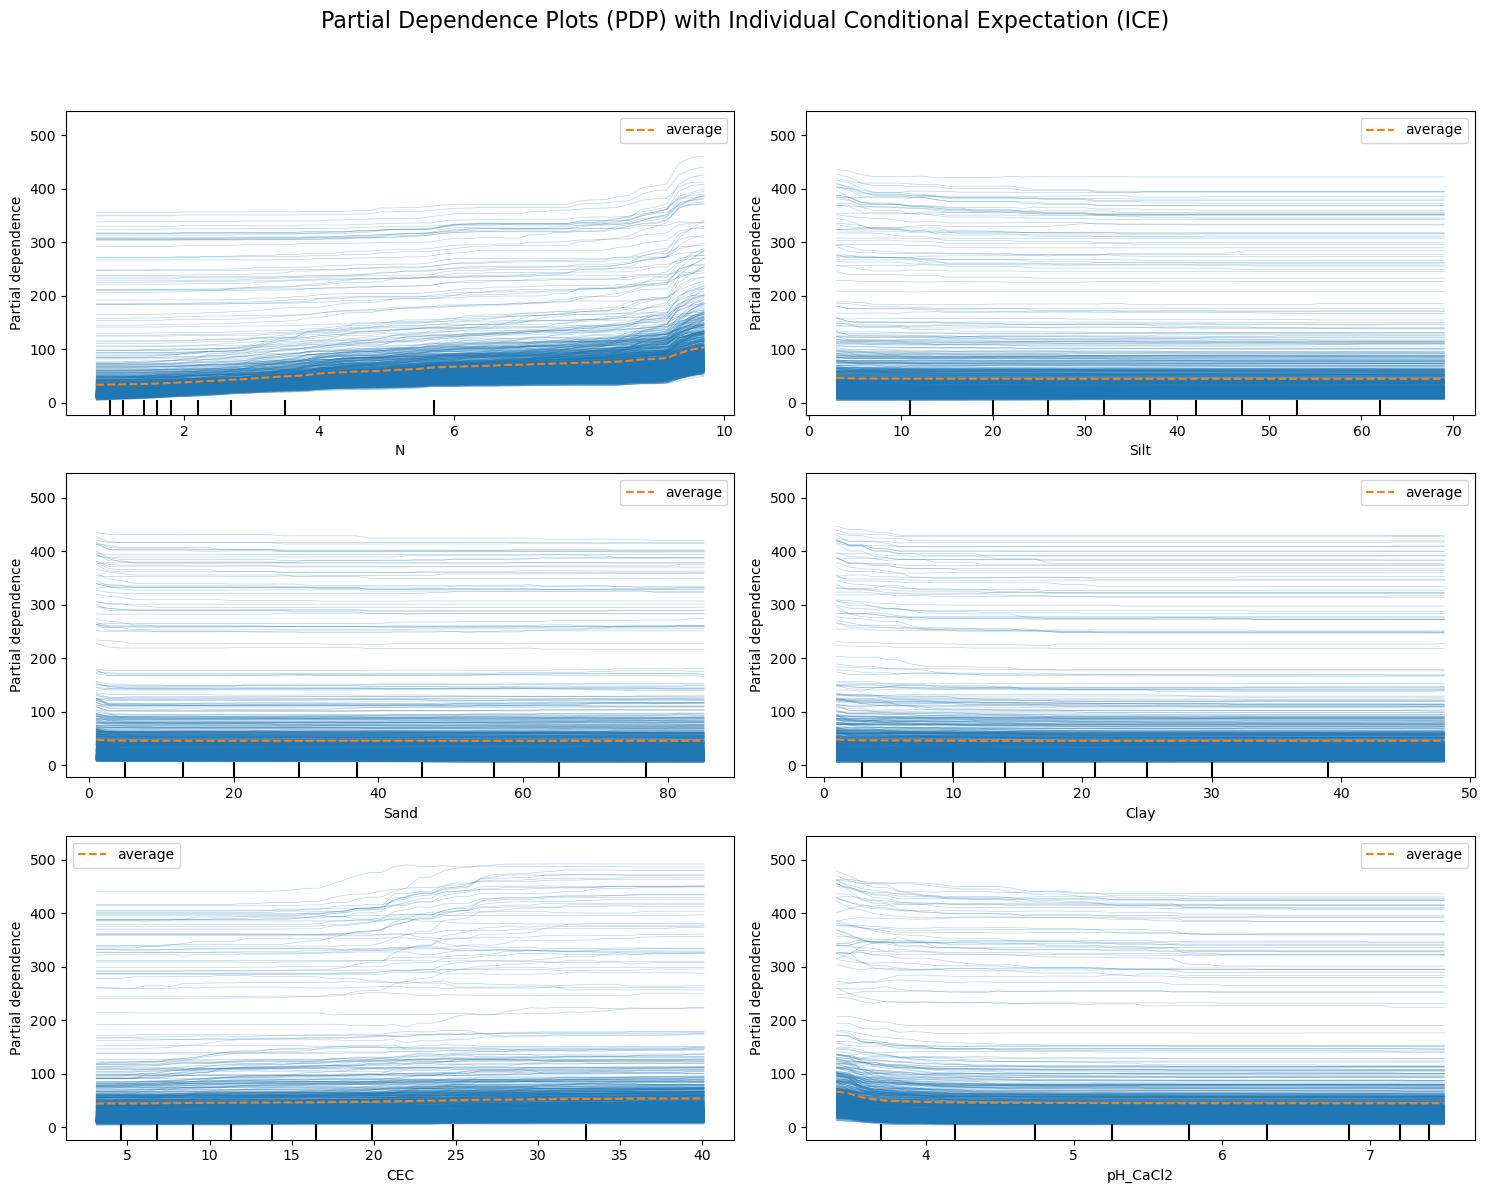


部分依赖分析绘图完成。
代码执行完毕。


In [16]:
from sklearn.inspection import PartialDependenceDisplay

# --- 8. 部分依赖分析和绘图 (Partial Dependence Plots - PDP) ---
print("\n--- 开始进行部分依赖分析 (PDP/ICE) ---")

# 选择要绘制PDP的最重要的N个特征
N_top_features = 6 # 你可以调整这个数量
top_features = feature_importance_df['Feature'].head(N_top_features).tolist()

print(f"将为以下最重要的 {N_top_features} 个特征绘制 PDP/ICE 图:")
print(top_features)

# --- 绘制 PDP 和 ICE 图 ---
# PartialDependenceDisplay.from_estimator 会自动处理图形布局
# kind='both' 会同时绘制 PDP（平均线）和 ICE（个体线）
# 使用训练数据 X_train_imputed 来计算依赖关系
# 'percentiles' 控制 x 轴范围，通常在数据的第 5 和第 95 百分位数之间显示，避免受极端值影响
# 'n_jobs' 可以加速计算过程
# 'grid_resolution' 控制计算 PDP/ICE 曲线时特征值的精细程度

# 注意：如果计算时间过长，可以尝试减少 N_top_features、降低 grid_resolution 或减少 ICE 线数量 (设置 subsample)
# 注意：对于分类特征（如 CLC，如果它是类别编码），PDP的解释需要谨慎。
#       最好在建模前对其进行独热编码（One-Hot Encoding），然后为每个独热编码后的虚拟变量绘制PDP。
#       如果 CLC 是数值编码（如 1, 2, 3...），当前的 PDP 会将其视为连续数值，可能难以解释。

try:
    fig, ax = plt.subplots(figsize=(15, 4 * ((N_top_features + 1) // 2)), # 调整图形大小以容纳子图
                         ncols=2, nrows=((N_top_features + 1) // 2)) # 创建子图网格

    display = PartialDependenceDisplay.from_estimator(
        best_rf_model,
        X_train_imputed, # 使用训练数据计算
        features=top_features, # 指定要绘制的特征列表
        kind='both', # 'average' 只绘制PDP, 'individual' 只绘制ICE, 'both' 都绘制
        subsample=1000, # 使用部分样本计算ICE线以加速（如果训练集很大），设为None或1.0使用全部
        n_jobs=-1, # 使用所有CPU核心
        grid_resolution=50, # x轴上的点数
        random_state=66,
        ax=ax.flatten()[:N_top_features] # 将图绘制到我们创建的子图上
    )

    # 调整布局和标题
    fig.suptitle('Partial Dependence Plots (PDP) with Individual Conditional Expectation (ICE)', fontsize=16, y=1.02)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局防止标题重叠

    # 如果子图数量是奇数，隐藏最后一个空的子图轴
    if N_top_features % 2 != 0:
        ax.flatten()[-1].set_visible(False)

    plt.show()

except Exception as e:
    print(f"绘制 PDP/ICE 图时出错: {e}")
    print("可能的原因包括：")
    print("- 内存不足（尝试减少 subsample 或 N_top_features）。")
    print("- 特征名称或数据类型问题。")
    print("- Scikit-learn 版本兼容性问题。")


print("\n部分依赖分析绘图完成。")
print("代码执行完毕。")

# 下数据

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import time
import re # 用于更精确地匹配文件名

# --- 配置信息 ---
# 注意：base_url 保持不变，因为它指向的是年/001/ 目录的父级
base_url = "https://www.glass.hku.hk/archive/NPP/MODIS/500M/GLASS_NPP_500M_YEARLY_V60/"
start_year = 2009
end_year = 2018 # 包含 2018 年
download_directory = "GLASS_NPP_EU_UK_Data" # 数据将下载到这个文件夹下

# 你之前确定的需要下载的瓦片编号集合 (涵盖欧盟所有成员国和英国)
target_tiles = {
    "h16v04", "h16v05", "h17v03", "h17v04", "h17v05", "h18v03",
    "h18v04", "h18v05", "h19v03", "h19v04", "h19v05", "h20v05"
}

# 下载文件之间的延迟 (秒)，防止请求过快
sleep_seconds = 1

# --- 确保下载目录存在 ---
if not os.path.exists(download_directory):
    os.makedirs(download_directory)
    print(f"创建下载目录: {download_directory}")

# --- 文件名匹配模式 ---
# 根据新的文件名模式 GLASS17E11.V60.A20xx001.hxxvxx.2022100.hdf 进行调整
# 匹配以前缀开始，以后缀结束，并捕获 hxxvxx 部分
# ^GLASS17E11\.V60\.A\d{4}001\.  - 匹配固定的前缀和年份日期部分 (年份用 \d{4} 匹配，不捕获)
# (h\d{2}v\d{2})              - 匹配并捕获 hxxvxx 部分 (例如 h17v04)
# \.2022100\.hdf$           - 匹配固定的 .2022100.hdf 后缀
filename_pattern = re.compile(r'^GLASS17E11\.V60\.A\d{4}001\.(h\d{2}v\d{2})\.2022100\.hdf$')

print(f"开始下载 GLASS NPP 数据 ({start_year}-{end_year})...")
print(f"目标瓦片编号: {', '.join(sorted(list(target_tiles)))}")
print(f"数据将保存到: {os.path.abspath(download_directory)}")
print(f"根据新的文件名模式进行匹配: {filename_pattern.pattern}")


# --- 循环年份进行下载 ---
for year in range(start_year, end_year + 1):
    # 目录结构仍然是 base_url / year / 001 /
    year_url = f"{base_url}{year}/001/"
    year_download_path = os.path.join(download_directory, str(year))

    # 为当前年份创建子目录
    if not os.path.exists(year_download_path):
        os.makedirs(year_download_path)

    print(f"\n正在处理年份: {year}")
    print(f"访问网页目录: {year_url}")

    try:
        # 获取网页内容
        # 设置一个较短的超时时间，避免长时间无响应
        response = requests.get(year_url, timeout=10)
        response.raise_for_status() # 如果状态码不是 200，会抛出异常
    except requests.exceptions.RequestException as e:
        print(f"错误: 无法访问 {year_url} - {e}")
        continue # 跳过当前年份，处理下一年

    # 使用 BeautifulSoup 解析 HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # 查找所有的链接 (<a> 标签)
    links = soup.find_all('a', href=True)

    download_count = 0
    found_files_for_year = False # 标记是否在该年份目录找到符合模式的文件

    for link in links:
        filename = link['href']

        # 使用正则表达式检查文件名是否符合模式并提取瓦片编号
        match = filename_pattern.match(filename)

        if match:
            found_files_for_year = True
            tile_id = match.group(1) # 获取 hxxvxx 部分

            # 检查瓦片编号是否在我们需要的列表里
            if tile_id in target_tiles:
                file_url = f"{year_url}{filename}"
                local_filepath = os.path.join(year_download_path, filename)

                # 检查文件是否已存在，如果存在则跳过
                if os.path.exists(local_filepath):
                    print(f"跳过文件: {filename} 已存在.")
                    continue

                print(f"正在下载: {filename} 到 {year_download_path}")

                try:
                    # 下载文件，使用 stream=True 处理大文件
                    # 同样设置一个超时时间
                    file_response = requests.get(file_url, stream=True, timeout=60) # 文件下载超时可以长一点
                    file_response.raise_for_status() # 检查下载请求是否成功

                    # 将文件内容写入本地文件
                    with open(local_filepath, 'wb') as f:
                        # 逐块写入，节省内存
                        for chunk in file_response.iter_content(chunk_size=8192):
                            if chunk: # 过滤掉 keep-alive 的空 chunk
                                f.write(chunk)

                    print(f"成功下载: {filename}")
                    download_count += 1
                    time.sleep(sleep_seconds) # 下载成功后等待一下

                except requests.exceptions.RequestException as e:
                    print(f"错误: 下载文件 {filename} 失败 - {e}")
                    # 如果下载失败，尝试删除可能存在的不完整文件
                    if os.path.exists(local_filepath):
                       try:
                           os.remove(local_filepath)
                           print(f"已移除不完整文件: {local_filepath}")
                       except OSError as cleanup_error:
                           print(f"错误: 移除不完整文件 {local_filepath} 失败 - {cleanup_error}")
                    continue # 继续尝试下载列表中的下一个文件
                except IOError as e:
                    print(f"错误: 写入文件 {local_filepath} 失败 - {e}")
                    continue # 继续尝试下载列表中的下一个文件


    if not found_files_for_year:
        print(f"警告: 在年份 {year} 的目录下 ({year_url}) 没有找到符合文件名模式的文件。请检查文件名模式是否正确。")
    elif download_count == 0:
         print(f"年份 {year} 找到了符合模式的文件，但都不在我们目标瓦片列表 ({len(target_tiles)}个) 中，或文件已存在。")
    else:
         print(f"年份 {year} 处理完毕。共下载 {download_count} 个文件。")

print("\n所有年份处理完毕，下载过程结束。")

开始下载 GLASS NPP 数据 (2009-2018)...
目标瓦片编号: h16v04, h16v05, h17v03, h17v04, h17v05, h18v03, h18v04, h18v05, h19v03, h19v04, h19v05, h20v05
数据将保存到: d:\study\组会\DATA\SOC\GLASS_NPP_EU_UK_Data
根据新的文件名模式进行匹配: ^GLASS17E11\.V60\.A\d{4}001\.(h\d{2}v\d{2})\.2022100\.hdf$

正在处理年份: 2009
访问网页目录: https://www.glass.hku.hk/archive/NPP/MODIS/500M/GLASS_NPP_500M_YEARLY_V60/2009/001/
正在下载: GLASS17E11.V60.A2009001.h16v05.2022100.hdf 到 GLASS_NPP_EU_UK_Data\2009
成功下载: GLASS17E11.V60.A2009001.h16v05.2022100.hdf
正在下载: GLASS17E11.V60.A2009001.h17v03.2022100.hdf 到 GLASS_NPP_EU_UK_Data\2009
成功下载: GLASS17E11.V60.A2009001.h17v03.2022100.hdf
正在下载: GLASS17E11.V60.A2009001.h17v04.2022100.hdf 到 GLASS_NPP_EU_UK_Data\2009
成功下载: GLASS17E11.V60.A2009001.h17v04.2022100.hdf
正在下载: GLASS17E11.V60.A2009001.h17v05.2022100.hdf 到 GLASS_NPP_EU_UK_Data\2009
成功下载: GLASS17E11.V60.A2009001.h17v05.2022100.hdf
正在下载: GLASS17E11.V60.A2009001.h18v03.2022100.hdf 到 GLASS_NPP_EU_UK_Data\2009
成功下载: GLASS17E11.V60.A2009001.h18v03.2022100.hdf
正在下载

In [3]:
import requests
from bs4 import BeautifulSoup
import os
import time
import re # 用于更精确地匹配文件名

# --- 配置信息 ---
# 注意：base_url 保持不变，因为它指向的是年/001/ 目录的父级
base_url = "https://www.glass.hku.hk/archive/NPP/MODIS/500M/GLASS_NPP_500M_YEARLY_V60/"
start_year = 2009
end_year = 2018 # 包含 2018 年
download_directory = "GLASS_NPP_EU_UK_Data" # 数据将下载到这个文件夹下

# 你之前确定的需要下载的瓦片编号集合 (涵盖欧盟所有成员国和英国)
target_tiles = {
    "h18v01", "h18v02", "h19v02", "h20v04"
}

# 下载文件之间的延迟 (秒)，防止请求过快
sleep_seconds = 1

# --- 确保下载目录存在 ---
if not os.path.exists(download_directory):
    os.makedirs(download_directory)
    print(f"创建下载目录: {download_directory}")

# --- 文件名匹配模式 ---
# 根据新的文件名模式 GLASS17E11.V60.A20xx001.hxxvxx.2022100.hdf 进行调整
# 匹配以前缀开始，以后缀结束，并捕获 hxxvxx 部分
# ^GLASS17E11\.V60\.A\d{4}001\.  - 匹配固定的前缀和年份日期部分 (年份用 \d{4} 匹配，不捕获)
# (h\d{2}v\d{2})              - 匹配并捕获 hxxvxx 部分 (例如 h17v04)
# \.2022100\.hdf$           - 匹配固定的 .2022100.hdf 后缀
filename_pattern = re.compile(r'^GLASS17E11\.V60\.A\d{4}001\.(h\d{2}v\d{2})\.2022100\.hdf$')

print(f"开始下载 GLASS NPP 数据 ({start_year}-{end_year})...")
print(f"目标瓦片编号: {', '.join(sorted(list(target_tiles)))}")
print(f"数据将保存到: {os.path.abspath(download_directory)}")
print(f"根据新的文件名模式进行匹配: {filename_pattern.pattern}")


# --- 循环年份进行下载 ---
for year in range(start_year, end_year + 1):
    # 目录结构仍然是 base_url / year / 001 /
    year_url = f"{base_url}{year}/001/"
    year_download_path = os.path.join(download_directory, str(year))

    # 为当前年份创建子目录
    if not os.path.exists(year_download_path):
        os.makedirs(year_download_path)

    print(f"\n正在处理年份: {year}")
    print(f"访问网页目录: {year_url}")

    try:
        # 获取网页内容
        # 设置一个较短的超时时间，避免长时间无响应
        response = requests.get(year_url, timeout=10)
        response.raise_for_status() # 如果状态码不是 200，会抛出异常
    except requests.exceptions.RequestException as e:
        print(f"错误: 无法访问 {year_url} - {e}")
        continue # 跳过当前年份，处理下一年

    # 使用 BeautifulSoup 解析 HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # 查找所有的链接 (<a> 标签)
    links = soup.find_all('a', href=True)

    download_count = 0
    found_files_for_year = False # 标记是否在该年份目录找到符合模式的文件

    for link in links:
        filename = link['href']

        # 使用正则表达式检查文件名是否符合模式并提取瓦片编号
        match = filename_pattern.match(filename)

        if match:
            found_files_for_year = True
            tile_id = match.group(1) # 获取 hxxvxx 部分

            # 检查瓦片编号是否在我们需要的列表里
            if tile_id in target_tiles:
                file_url = f"{year_url}{filename}"
                local_filepath = os.path.join(year_download_path, filename)

                # 检查文件是否已存在，如果存在则跳过
                if os.path.exists(local_filepath):
                    print(f"跳过文件: {filename} 已存在.")
                    continue

                print(f"正在下载: {filename} 到 {year_download_path}")

                try:
                    # 下载文件，使用 stream=True 处理大文件
                    # 同样设置一个超时时间
                    file_response = requests.get(file_url, stream=True, timeout=60) # 文件下载超时可以长一点
                    file_response.raise_for_status() # 检查下载请求是否成功

                    # 将文件内容写入本地文件
                    with open(local_filepath, 'wb') as f:
                        # 逐块写入，节省内存
                        for chunk in file_response.iter_content(chunk_size=8192):
                            if chunk: # 过滤掉 keep-alive 的空 chunk
                                f.write(chunk)

                    print(f"成功下载: {filename}")
                    download_count += 1
                    time.sleep(sleep_seconds) # 下载成功后等待一下

                except requests.exceptions.RequestException as e:
                    print(f"错误: 下载文件 {filename} 失败 - {e}")
                    # 如果下载失败，尝试删除可能存在的不完整文件
                    if os.path.exists(local_filepath):
                       try:
                           os.remove(local_filepath)
                           print(f"已移除不完整文件: {local_filepath}")
                       except OSError as cleanup_error:
                           print(f"错误: 移除不完整文件 {local_filepath} 失败 - {cleanup_error}")
                    continue # 继续尝试下载列表中的下一个文件
                except IOError as e:
                    print(f"错误: 写入文件 {local_filepath} 失败 - {e}")
                    continue # 继续尝试下载列表中的下一个文件


    if not found_files_for_year:
        print(f"警告: 在年份 {year} 的目录下 ({year_url}) 没有找到符合文件名模式的文件。请检查文件名模式是否正确。")
    elif download_count == 0:
         print(f"年份 {year} 找到了符合模式的文件，但都不在我们目标瓦片列表 ({len(target_tiles)}个) 中，或文件已存在。")
    else:
         print(f"年份 {year} 处理完毕。共下载 {download_count} 个文件。")

print("\n所有年份处理完毕，下载过程结束。")

开始下载 GLASS NPP 数据 (2009-2018)...
目标瓦片编号: h18v01, h18v02, h19v02, h20v04
数据将保存到: d:\study\组会\DATA\SOC\GLASS_NPP_EU_UK_Data
根据新的文件名模式进行匹配: ^GLASS17E11\.V60\.A\d{4}001\.(h\d{2}v\d{2})\.2022100\.hdf$

正在处理年份: 2009
访问网页目录: https://www.glass.hku.hk/archive/NPP/MODIS/500M/GLASS_NPP_500M_YEARLY_V60/2009/001/
跳过文件: GLASS17E11.V60.A2009001.h18v01.2022100.hdf 已存在.
跳过文件: GLASS17E11.V60.A2009001.h18v02.2022100.hdf 已存在.
跳过文件: GLASS17E11.V60.A2009001.h19v02.2022100.hdf 已存在.
跳过文件: GLASS17E11.V60.A2009001.h20v04.2022100.hdf 已存在.
年份 2009 找到了符合模式的文件，但都不在我们目标瓦片列表 (4个) 中，或文件已存在。

正在处理年份: 2010
访问网页目录: https://www.glass.hku.hk/archive/NPP/MODIS/500M/GLASS_NPP_500M_YEARLY_V60/2010/001/
跳过文件: GLASS17E11.V60.A2010001.h18v01.2022100.hdf 已存在.
跳过文件: GLASS17E11.V60.A2010001.h18v02.2022100.hdf 已存在.
正在下载: GLASS17E11.V60.A2010001.h19v02.2022100.hdf 到 GLASS_NPP_EU_UK_Data\2010
成功下载: GLASS17E11.V60.A2010001.h19v02.2022100.hdf
跳过文件: GLASS17E11.V60.A2010001.h20v04.2022100.hdf 已存在.
年份 2010 处理完毕。共下载 1 个文件。

正在处理年份: 2011
访问网